DHvs NR binary classifier
Script overview: 
1. Block 1 of the script imports KS domains from files in "route" and combines with substrate labels generated from file "labels_sheet", then balances the dataset based on the minimal category 
2. Block 2 generates graph networks from carbon alphas using a k-nearest neighbour method. Features are supplied as a OHE of amino acid type. Labels are unified in the graph constructor as graph_y.
3. Block 3 is a dataloader. KS substrate type is balanced in this block for Train, Validation and Test data.
4. Block 4 contains the GNN model, training loop and test step.
5. Block 5  loop that explains each graph in the test data partition.

In [8]:
#### Block 1 #### 
### Import pdb files and labels -> prepare for graph creation ###
import os
import torch
import graphein
import pandas as pd
import re

## Import pdb files ##
route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240911_KS_dimers_extras_aligned_reviewed/"
# List of filenames in the pdb folder "route" #
filenames = os.listdir(route)

# Create a list of absolute file paths in route # 
absolute_file_paths = [os.path.join(route, filename) for filename in filenames]

## Import labels from file and create a dataframe matched to pdb files ##
label_sheet = pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231108_KS_expandedset_reduction_state_labels_new_borders.csv")   # expanded set adds 23 more clusters

# Extract gene names from file names
gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Filter labels for the matched gene names
matched_labels = label_sheet[label_sheet.iloc[:, 0].isin(gene_names)].set_index(label_sheet.columns[0])

# Create a list of gene names from the absolute file paths
file_path_gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Reorder matched_labels to match the order of absolute_file_paths
reordered_labels = matched_labels.loc[file_path_gene_names]



# Add paths # 
reordered_labels["paths"] = absolute_file_paths


         
NR_total = sum(reordered_labels['NR'])
print("No reduction:", NR_total) 
KR_total = sum(reordered_labels['KR'])
print("KR:", KR_total) 
DH_total = sum(reordered_labels['DH'])
print("DH:", DH_total) 
ER_total = sum(reordered_labels['ER'])
print("ER:", ER_total) 
total_states = NR_total + KR_total + DH_total + ER_total
num_genes = len(reordered_labels)
print("Total reduction states:", total_states)
print("Number of genes:", num_genes)

# Divide labels
categories_list = [ 'NR','DH']
minimum_category = min( NR_total, DH_total)
sample_size = minimum_category

#sample_size = 117 # You can set this to your desired sample size

padded_categories = []

for category in categories_list:
    category_rows = reordered_labels[reordered_labels[category] == 1]
    print(len(category_rows))
    num_samples = min(sample_size, len(category_rows))
    category_rows = category_rows.sample(n=num_samples)
    if num_samples < sample_size:
        additional_samples = category_rows.sample(n=sample_size - num_samples, replace=True)
        category_rows = pd.concat([category_rows, additional_samples])
    
    padded_categories.append(category_rows)

# Concatenate the original data with the padded categories
balanced_reordered_labels = pd.concat(padded_categories)

# Reset the index to ensure it's unique
balanced_reordered_labels.reset_index(drop=True, inplace=True)

# Print the counts for each category after balancing
for category in categories_list:
    category_count = len(balanced_reordered_labels[balanced_reordered_labels[category] == 1])
    print(f"Balanced {category}: {category_count}")

balanced_reordered_labels2 = balanced_reordered_labels.drop('paths', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('KR', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('ER', axis=1)

graph_label_map = balanced_reordered_labels2.to_dict(orient='index')


No reduction: 121
KR: 361
DH: 383
ER: 165
Total reduction states: 1030
Number of genes: 1192
121
383
Balanced NR: 121
Balanced DH: 121


Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning:

The default value of regex will change from True to False in a future version.

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning:

The default value of regex will change from True to False in a future version.

[06/25/25 11:38:51] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=389441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=283780;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 826 total nodes                                                 ]8;id=856616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=806695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

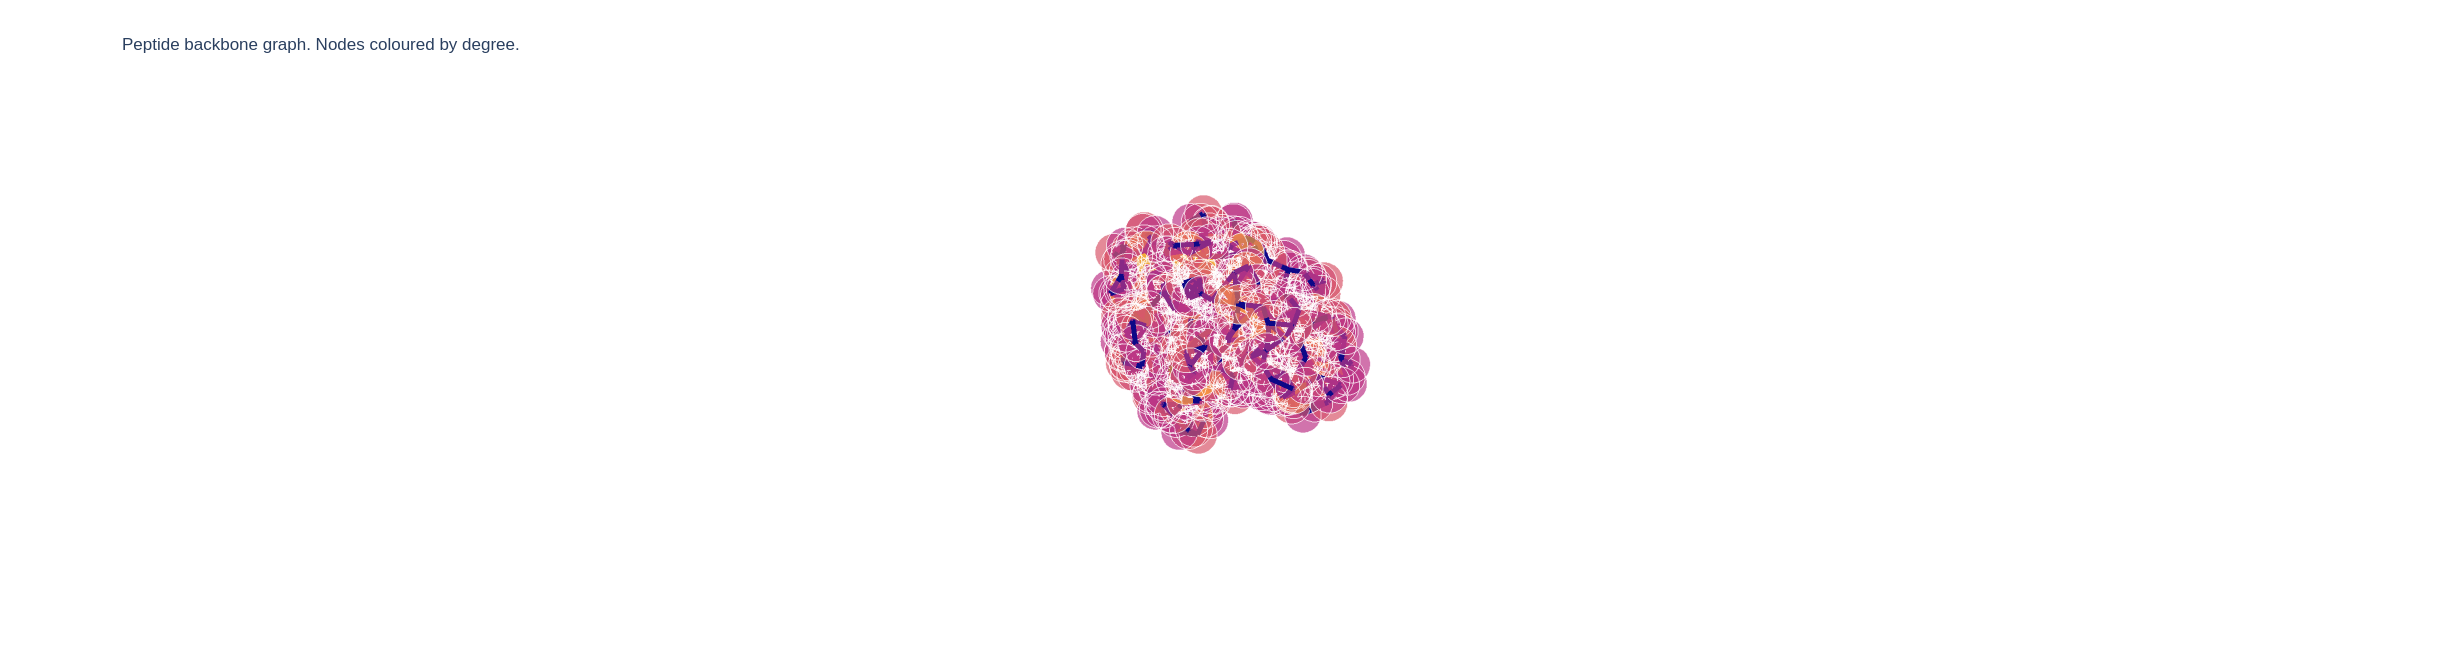

Processing...
  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

[06/25/25 11:39:18] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=556758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=553685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=627236;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=644752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=700310;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637999;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=777784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=656938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=465973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=262329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=735670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=447626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=319602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=427350;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=660280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=542129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=476332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=260635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=607611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=597181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=246123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=648070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=403863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=713048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=834044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=861386;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=564937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=423079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=337298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=825730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=313507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=698987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97463;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=299169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=964307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=564039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=772070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=502607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=712909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=497450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=568964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=599833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=430060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=150079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=96106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=17320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=536799;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=25417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=823697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=670450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=188988;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=419605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=920308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=202167;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=383136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=876285;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=784135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=872740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=245575;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=879176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=936484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=855573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=444621;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=394977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=254511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=245996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=449915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=649495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=847130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=717542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=378674;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=278675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=99844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=92179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=993944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=716470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=312065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=388390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=96073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=10764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=545530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=656897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=728476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=99942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=119304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=92358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=722194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=301063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=559459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=529481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=569963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=867482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=396499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=493093;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=640356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=424603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=400486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401621;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=771400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=290796;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=879932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=938775;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=578154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=635635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=586670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=123829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=697631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=75658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=448823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=617272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=324163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=236754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=654263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=281309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=292746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=672790;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=461583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=521655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=886817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=995195;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=199681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981550;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=217256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=963753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=994595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=213659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=142471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=313914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=978700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=285354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=754620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=2217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=515615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=829332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=113699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=697901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=964114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=737161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=556207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=469896;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=512707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=581754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=768708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=792939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=776703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=154846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=134705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=407623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=528492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=766375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=399403;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=896091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=622230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=801773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=363281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=883044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=429261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=181140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=192188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961454;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=225468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=991595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=724318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=649426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=986578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=540222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=782685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=520599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=71852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=253121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=529602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=723115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=762219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=392104;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=42346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=268943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=234867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300145;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=212519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=122966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=667263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=87316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=891822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=783767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=303394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=754709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=313836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=262367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=753596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=973534;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=781001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=622651;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=939023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=678661;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478796;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=605335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=284931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=621689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:19] WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=404412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=654720;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=174375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=451230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=568272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=264424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=152156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=28631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=190798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=691385;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=642748;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=10835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=112487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=498131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=322765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688831;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=405695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=232570;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=70634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=461547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=960776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=629315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=104944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=479191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=198186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=706618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=591475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116950;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=631055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=874039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=469549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=895149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=887864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=553938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=188704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=510801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=835225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=769971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=313799;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=305211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=186095;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=887441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=886957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=947547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=317597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=213380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=649257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=141038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=578096;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=582778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=197664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=720701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=612204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=62507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=887301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=933195;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=513612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=29932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=748408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=704737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472462;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=372208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=593259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=876282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=567794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=241694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=359331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=938921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=710860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=559077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=259959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=604254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=307798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=477486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=203466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=956858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=261469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780491;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=159865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=342874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=736197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=388740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=317045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=827506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=967866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=891805;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=909224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=632369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=397246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=261369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17851;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=717311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=843479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=58562;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=800718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=294233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=426758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=933609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=373689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=372917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=281938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=900597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=989328;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=415896;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=92413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=396230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=590034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=602216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=486835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=596139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=32153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=435515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=630821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=374227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=882987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=497322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=744311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=15264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=313174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=170714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=37250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975215;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=590366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=278439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=426929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=582904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=698040;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=630358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=158420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=656187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=833003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=714474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=275832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=990065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=459238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=755813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=397379;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=136274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=52998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=87836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=203902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=212588;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=569879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=484079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=655193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=585974;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=147607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=104171;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=82644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=366519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=170329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218370;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=122448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=790475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=89085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=619792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=146509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=537395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=517470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=120844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=822731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=445822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=371523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=856015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=95100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=513405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=292508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=734997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=930498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=422443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=494211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=247653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=934904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=903448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=419723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=703732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=594551;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=48528;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=307705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=977878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=812451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=4080;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=965226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=804464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=537492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=425120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=549176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681067;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=394196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=564270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=283579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=418122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=646268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=640916;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=419555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=470501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=523515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=102994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=569455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289610;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=689426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=572846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=810586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=144627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=907328;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=712365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=432942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=635423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=941287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=95794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=241504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=718111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=700027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=710262;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=893119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=176235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=864042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=96695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=683998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=828069;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=706219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=321264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=373128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=575941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=856779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=932682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=176872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=744794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=234177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=452311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=253937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=88191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=48573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=469872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768526;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=685261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=479389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=665134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66357;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=41098;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=910901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=82267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=195051;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=612324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=749699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=413779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=581814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=282380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=933759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=4136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=341034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=651665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=342866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=71970;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238851;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=834235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=595947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36164;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=15378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=916541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=789189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=313559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=194876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=571006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=790717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=513038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=141925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=25199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=159193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=403930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=493324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=305725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=748872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=442902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=374512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=172329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=331309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=901998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=951759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=236970;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=804461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=727697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=276272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=161390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=732628;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=505120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=937506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=566053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=167633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=444624;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=749822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=914428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=95021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=378449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=450147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=604789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=315023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=551370;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209275;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=348412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=880325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=237475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749337;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=349627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=771276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=708347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=515291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=417930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=420693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=563582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=649117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=225620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=162005;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=261969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=84522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=429932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=610156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=358407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=598075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198968;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=645431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=207191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=769344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=329911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=356655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=216679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=336397;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=414281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=880010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=693687;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=31265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=631561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=641261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=16017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=921138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=431992;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=205771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=438704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=546016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=451931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:20] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=591490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=237446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=776873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=712029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=666590;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=19380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=329236;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=445581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=247925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=628638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=494973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=100271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=706085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=467977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=774531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=901911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176687;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=75317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=223093;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=841780;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=81763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=935583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980927;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=287791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=645348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=935087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=631838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=381328;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=982522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=805503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=689146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=684506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=228323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=668092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=954044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=835030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=491731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=478378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=456210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=521193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=345460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=25194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=800387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=955671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=986884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=790581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=186849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=978711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=462139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=293142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=969349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=120024;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=704960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=957488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=1249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=952225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=951982;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183043;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=167005;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35080;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=46609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=929523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=171706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=863027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=91284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=366297;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=865803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759159;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85984;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=777606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=322926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=621151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=182599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=390400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=680864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=959554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=991092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=335163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=196066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=460595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=702869;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=578785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=562028;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=551871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=948640;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=600987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=38306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=910865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=644708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=503481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=558731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=209659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=767900;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=787392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=450142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=697354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=764192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=325721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=164644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=678865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=377189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=843118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=910816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=885295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=261462;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=258711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=277185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=480814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=877875;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=575717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=467563;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=525776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=128899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=152765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=803033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=737712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=319754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=1363;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=661928;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=280661;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=432053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=661258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=964648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=549923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=8925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=732488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=726353;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=539746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=550750;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=360511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=731729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746928;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=117735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=350733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=551236;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=452082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=562600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956454;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=740168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=534785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=689874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=589972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=629030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=938112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=666877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=22420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=577692;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=423743;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=88551;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=606318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=144801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=325504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=31075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=389292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=582977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=192125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=9304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=922445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=506986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=335839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=456946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=86392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=587667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=817234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=66728;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=130785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=388163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=928480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842093;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=424311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=770044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=797151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=614424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:21] WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=980401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=317161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=660514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=102615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=416023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=543039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=148003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=56516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=260787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=461253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647102;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=287680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=976346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=873748;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=535858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=586838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=719975;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=499905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=139731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=368022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=543765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=579644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=377545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=943316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=712923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=710533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=997725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=893407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=522428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=564919;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=752384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=246590;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=594336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=997670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=156446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=872886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=847134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=669842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=790957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=645314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=843193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=177485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=518779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=442753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=413412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=702667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=710894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=867629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=856139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=801186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=580024;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=803648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=866446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=516076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=564688;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924414;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=752759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=63191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=241188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=946500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=170136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=589878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=891340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=682162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=834296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=675649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=385058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=803838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617383;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=807627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=321471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=709756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=255874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=686019;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=321729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=935272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=53903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=821395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=440516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=946522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504297;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=125810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=284834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=271994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=609913;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=140698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=959450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=235092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=669366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=536600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=337442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=331531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=790468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=85149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=99130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=822576;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=911640;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=208103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=756224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=608931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=21230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=567613;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=193482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=486095;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=131378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572510;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=632825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=602556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=830271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=48474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=898840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=202307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=407169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=431220;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=614083;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=593004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=705640;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=48613;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=171522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=613072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=95996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=584633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=994583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=947698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300102;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=204200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=805116;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=507675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=398434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=490909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=313358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=550841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=982813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124907;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=378984;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=558523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=284241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=526808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=548618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=901829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=498529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=68465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=186863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=621927;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=915405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=704843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=230169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=953282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=55732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=586097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=714031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=832972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=330390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523624;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925403;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=709249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=468753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=960238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=516042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=720275;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=292497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=484560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=615548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=171683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=172311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=766320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=393861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=518103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=967917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=325795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=228732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=955205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=808978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=561364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=634485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=855392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=697398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797741;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=845497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139285;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=122348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=576021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=596130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472598;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=999609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=93606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=825860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=169010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=348377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=487167;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=41374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867159;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=342525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=538973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=114316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=549304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=268138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=872535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=949003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=560242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=734147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=929029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=659636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=965475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=751556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=692486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=411738;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=89061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=235046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=826602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=835643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=867800;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=348589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=728762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=328370;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=588329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=490353;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=273759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=881158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=939480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=832958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=927543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=779190;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=578464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=701035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=274124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=22946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=585559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=568724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=45242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=753127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=649849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=453084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=642336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=250711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=360931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294883;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=136502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=335539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=308200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=492296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=212991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=262521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=864110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=594093;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209059;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=146799;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=135996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=584097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=668265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=248277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=47948;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=682500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=623570;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=247604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=372807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=86767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=497171;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=112268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=717764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=403700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=873657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=176631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=254014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=526941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=558475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=728951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=939974;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=168261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=943077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=934673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=485632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=250505;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=548622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=483432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=573195;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=456178;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=375503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=467614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=84483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=256833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=587324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=821304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:22] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=219904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=64597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=435758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=287540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=564513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=278599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=122833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=163447;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=308897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=363682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=211980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=601538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=640714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=932924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=768054;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=975746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=860252;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=30838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=410621;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=761210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=8117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=654516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=127840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=686708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=423560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=889135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=94626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=734300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=754267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=646622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=532389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=511787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=992788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=922112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=594795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=890530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=928196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=534010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=32612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=93601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=383899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=658848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=546091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=273256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=472789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716203;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=407747;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=466019;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=521746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=641472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=962194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=178318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=98587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=314439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=789954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=890751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=272337;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=19168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=769184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600576;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=247044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=715067;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=439926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311869;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=613103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=9319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=398249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=946003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=625655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=598596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=73154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=443711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=784678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=908373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=585593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=184738;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=967335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=180367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=506739;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=349801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=341072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=935567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=668329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=713275;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=127810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=940803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=621594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=69051;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=457253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=454662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=404343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=216577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=237148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=699184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=806836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=754675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=182245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=228022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=192410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=580549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=149377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=468943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=403596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=522357;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=856630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=907366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=844574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=395911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447273;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=833670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=15348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=894044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=30798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=11505;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=727694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=577313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=510001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=252254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=42245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=79868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=640933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=548806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=102299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=726810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=53068;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=482092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=849242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=660381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=346526;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=769342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=329919;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443041;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=197663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=631325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=867261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=516130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=718155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=669550;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=2978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=91062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=248717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=937946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=991163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=449681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=971126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=730809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=136734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=945773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=942532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=247433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=454438;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=267920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=331322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=9160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=371413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=555785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=591605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=483709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=464767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=385966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=194106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=792921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=516413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=713497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=287861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=80689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=812276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=363575;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=859972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=305479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=236635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=477294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=468200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=362040;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=434941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=340507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=187232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=854290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=760305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=689199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=526706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=438655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=928738;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=588566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=787622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=226959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=553767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=214253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=892534;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=720228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=574457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=877567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=357898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=685722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=883367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=106488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=854422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=725360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=858632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=709907;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=642226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=642323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=250438;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=986106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=799281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=427707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=46772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=457035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=656324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=45037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530339;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=695101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=314960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=719259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=750446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=825674;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=574855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=624363;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=870560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=87981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=331196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=189295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=922527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=309679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=579250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=569449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=64141;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=978809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=816138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=944471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=745836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=847240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=346820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=564828;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=12108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=995154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=453969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=200014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=45573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=687032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=193431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=403466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=301932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=220212;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=390137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=990320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=97362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=954544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=96091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=293836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=41409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=234858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=152941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835098;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=232520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=29873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=33611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=111810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=282470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=753520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=557166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=450457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=651316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=928963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=45409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=353990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=995698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:23] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=969606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=840181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=876331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=120910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=753390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=872982;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=355294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=53204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=180304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=536963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=659620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=394139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187517;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441580;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=431280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=396722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=563760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=39668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=550876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=849449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=594340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=541434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=152883;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=894509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=266773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=840095;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=987203;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=678854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=792120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=622469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663421;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=429854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=6933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=739406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=820850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=748323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=806979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=665487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=963872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=237129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=540124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=252173;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=874650;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=348009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=539559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=277223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=931991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=146884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=197161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=909542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=556435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=987737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=647407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=341967;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=871827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=568678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=442853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=910705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=836249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=910327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=879644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=302134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=50245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=420723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=391048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=317085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=788715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=92886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=800702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=106148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842011;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=875453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=631645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=79714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332913;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=830917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=37248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=264307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=720756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=392274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=198171;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=995210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=536243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=534754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=358714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=433481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=305325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=460380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=658468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=102230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=438733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=327056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=983970;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=570276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=154536;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=402765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=630929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=557893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=163801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=365133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=817810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=888110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=224518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=496819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=760727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=353880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276536;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=78292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=861920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=329862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=49064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=63944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=858605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=462605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=292126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=507554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=502124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=151732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=597013;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=900604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=687540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=855509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793157;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=979481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=752262;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=135245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=66625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=74362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=248342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153799;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=657624;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211080;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=921432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=757036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=509810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=431824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=214243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=237906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323869;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=961859;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=18662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=603196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=810695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=412553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=274892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=254885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=316653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=297836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=199225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=345042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=604690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=477703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=848957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=328983;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=614408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=135843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=931213;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=682565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=982755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=557616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=250674;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=133081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=723558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=614462;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=286700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=203281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=565635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269397;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=693807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=26678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=205278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=213718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=848152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=310390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=249843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=192494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=329792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=83118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=863877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=292582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=791798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=147731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=551079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=994952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=438733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98537;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=202504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114201;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=645131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=70979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=361113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=162437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=293292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=963751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=870890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=219585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=162373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=683877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=159916;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=304259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=4412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=847426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=919914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=28378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=73605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=870128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=895390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=699298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=499088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=38701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=909542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=965345;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=993266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=357179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=493812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=306416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=5226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=473554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=306215;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=998394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=247087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=911064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=924365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=314500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=695376;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=477828;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=719278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=376492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=921911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=577852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=578641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=211352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=93936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=740970;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=895277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=674040;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=869366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=131993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=385003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=657672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605011;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=573782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=287649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=329626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=133225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=971517;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=58991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=195682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=113002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=188901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=285571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=571439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20802;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=765352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=146921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=302204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=648395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=167677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=150417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=804224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=83060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:24] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=889553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=353323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=984718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=109300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=540632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215766;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=835951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=60470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=559404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=4360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=105267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=615188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=167761;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=237834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=202944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=739225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=247695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=614284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=398569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=721503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=272328;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=550529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=986835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=593874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=621451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=174880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=796343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=205255;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=971986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=854218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=557860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.05s/it]

  0%|          | 0/114 [00:00<?, ?it/s]

[06/25/25 11:39:49] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=926195;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=396773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=856611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=230557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=695685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=999809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55856;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=625643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=392639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=964038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=769744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=88384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=353901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=777006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=898358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=868818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=930920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=882987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=736975;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=601737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=730518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=430980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=110894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=127339;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=81968;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=571639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=9014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=406305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=163760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=337670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=978307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=7439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=393287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=506619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=547908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=100562;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=295086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=602581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=779469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=458506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=547015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=126583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=861976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=345854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=134015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=717063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=845302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=190304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=586353;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=430971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934261;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=994781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=899867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=927319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=594627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=569887;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=4645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=45888;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=857652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=916251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=209191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=224501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=314964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=434406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=138075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=451340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=131997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=18375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=396076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=121395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=765905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=23667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=75507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=595803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=335307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=840636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=455870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55661;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=363399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=491729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=868796;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=144886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=261909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=770850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=95520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266330;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=180491;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=123464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=174097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=421642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=705947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=631777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=609602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=480472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=307908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511955;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=846609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=953964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=604290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=710111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=221890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=106057;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=14035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=681292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=927846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=104419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=724416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=434792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=567901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=885662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334080;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=352238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=374922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=849006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=629580;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=283055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=273461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=627141;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=744877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=380300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=524143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=865898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=704978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=928612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=878030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=93961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=915693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=810364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=283887;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=201557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=620138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=407354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674950;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=815073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=292034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=269627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=342687;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=659578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=830644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=95237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=172917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=917577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=451859;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=214745;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=275785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=876905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=195183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=258889;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=892897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=188633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=185721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=853760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=853666;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=69553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=725975;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=160685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665687;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=910743;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=936074;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=274729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=117658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=337714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=790063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=87277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=583746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=846663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=472623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=930198;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=592299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=429054;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=899757;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67710;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=347971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=851565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=629098;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=216468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=255144;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=673260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=388711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=359852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=216833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=908385;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=144899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=537302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=109933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=684298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=892110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=348691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=349578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=837165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=362921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=63151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=110405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=968253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707761;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=179049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=541334;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=905588;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=422463;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=854917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=101676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=999509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=313172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=54034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=442724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=182510;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=272088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=292240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=722798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=475470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=83156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=534428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=725946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=107806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=227841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=878341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=466429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=205074;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=468539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=307841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=390445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=851932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=935416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=595224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=787060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=84053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=648539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=472848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=450372;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=610987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=46038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=959683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=830189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=651008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=949161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=142923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=767194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:50] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=999405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=641425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=580311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=395857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=40555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=645606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=7151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=317027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=997466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=722840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=277777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=583689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=315469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=324002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=939318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=858238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=164097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=823734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=289856;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=210519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24650;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=554089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=500751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=149800;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=692594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=608170;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=616503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=522453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=159717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=751229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=179378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=878620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=817030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=932974;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=557599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=889070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576353;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=861224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=758299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=372741;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=295004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=407140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688175;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=786974;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=370227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=813191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=876538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=242431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=424323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=297755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=372071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=554514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=59630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=636694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=208510;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=901645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=952500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=824296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=568124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=393790;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=955155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=241213;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=764753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=998277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=354538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=31516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=579484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=889251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=342978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=740016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=681006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=789100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=696124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=466138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=920041;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=159899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=418327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=668268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=883923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=152104;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=881871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=731404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=494935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=299499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=880008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=72753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=838906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=197111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=286224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=869711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=405469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=8128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=909946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=907268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=409518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=544648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=469017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=42793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=772193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=710757;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=982283;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=37813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=718289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=963139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=499450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=14555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=303469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=485401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=876603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=690459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=487018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=410792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=146429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=118969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=698583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=235309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=10711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=241945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=540659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=737490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=915895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=749279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=374884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=942063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=403378;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=88906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=999281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=106638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=28153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=311809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=953020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=609087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=46638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=509203;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=979147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=778361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=714848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=893099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=274988;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=544458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=614106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=443424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=28932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=994479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=330341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=308185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=420174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=62968;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=353876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=612123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=525440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=691646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=357198;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=447360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=809049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=957149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=433898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=237452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=257620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=747781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=526591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=536419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=740410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=643301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=785997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=397329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=360219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=394238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=409219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=214703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=462771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=128512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677386;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=631426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=80971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=289256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=288120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=186332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=290883;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=525010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=846947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=747088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=961314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=189283;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=219876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=535654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=60415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=399795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=858754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=874746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=223018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=525495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=473396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=23045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=17026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=291294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=789122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=216065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=843876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=84209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119011;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=272497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=219266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=701574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=72780;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=926667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=602693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=954363;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=604135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=806362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=745846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=889036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=864413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=557577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=162874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=803550;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791215;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=402623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=642500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674379;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=314846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=621917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=721330;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=708476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=767778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=575443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531661;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=985873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=52139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=86524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=502520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=886742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=63854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=114836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=409394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=162914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=205094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=488293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=943699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=562646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=49971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=474446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=651850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=819253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=550358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=699893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=485556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=59871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67741;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=20732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=526731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=445555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=536615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=641797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=434393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=134898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=745770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=545258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35383;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=76264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=536760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=60945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=870643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=727652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=180691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=743624;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=345507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240688;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=829704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=150995;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=878798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=65151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=78992;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=812113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=50387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=935233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=724776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=197134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=554961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=422049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=69522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=91873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=696816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=398597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=836367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=223972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845329;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=598755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=428835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=480932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=839061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=51162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=903866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=332542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=15899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=437340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=331404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=555921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=581605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=670945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=777313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=248786;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=150441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=557160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=588197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=328482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=443003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=545683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:51] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=898696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=620882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=757360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=11352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=173269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=874905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=99978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=622808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=61033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=562811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=437096;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=451531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=790156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=353055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=131112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=111846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=905685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=325126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=271705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=737091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=440614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=593794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=481897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=299523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=852838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=823369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=19109;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=990975;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=750621;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=253973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=618250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=458196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=954139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=124926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255749;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=131773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952333;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=876647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=697371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=972824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=674918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=414767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=118308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=466534;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=840909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=378106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=676249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=130216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=917532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=109342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=479750;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263388;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=167235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=569492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=486105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=541227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=72595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=362647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=199811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=731017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=66690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=381086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=528236;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=656441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=968276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=847791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=128266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=241315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=392222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=689661;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=920480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=314422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=617490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290220;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=2348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=140071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=89351;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=36921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=843073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=244892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=626062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=393929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=822814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=437467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=418980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=86956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=128672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=146512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=809516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=156643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=393503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=470657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=861715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=779966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=53588;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=754457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:52] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=562930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807414;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=670700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=55557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=668585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=275182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=184213;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=826913;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=58502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=820828;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=742614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=825747;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=793727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=773490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=902042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=406111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=329870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=250949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=333412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=957801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=113954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=282443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=922553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=225107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=743464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=314073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=816860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=756535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=984068;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=412623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=793165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=946861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=884683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=575499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=57503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=673675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=641457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=244483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=179744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=468301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=704508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=530419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=643183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=1694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=667263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=834934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=611466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145421;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=65408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=982483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=568880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=970781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=57837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=897009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=668898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=321560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=279517;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=896497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=683779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=212405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=12758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=483577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=510753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=69437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=695437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=109631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=978146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=317250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=12774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=306609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=151742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511345;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=868433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=687609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=552331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=791221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=109846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=586345;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=747455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=64265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=735645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=204138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=490161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=518217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=272500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=776320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=768580;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=675822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741975;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=818669;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=908676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=596969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=150298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=63077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=751559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401436;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=184150;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=901217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=637116;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=165214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=805973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=860017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=884230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=517412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=400805;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=468769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=306181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=882804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=233393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=432226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=621425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=168709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=401677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=889026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=32116;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=316260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=772482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=346767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=820018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=383186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=325940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=836134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=565641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=608752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=487876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=694301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=189993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=891433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=449277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=994544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=276225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=402853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=521864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665383;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=556178;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=177427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674244;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=483903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=657071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13051;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=847590;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66321;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=71565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=724043;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=757310;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=35335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=779665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=340025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=799740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=967456;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=400084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=278156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=201611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=174831;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74562;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=804556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=731680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=640945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=93824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=523410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=627591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=767549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968572;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=798291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=415593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=673727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=872295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=96407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=949618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=530472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=526807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=47653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=628046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309403;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=769709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=502050;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=120524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=257774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=417560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=866249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=292802;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=187086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=622175;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=784469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=467472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=999816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=260948;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=191587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=315707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=905969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=206608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=612802;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=108344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=818015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=800309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=377334;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=787545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=418180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=613140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=339101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=564371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=389821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=34706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=816960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=650349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=349201;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=362031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=683928;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=200881;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=952034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=469134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=211695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=723503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=249696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=70659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=348807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=634541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=603207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=901283;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=85301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=143909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=687118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36692;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=691639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=618519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=16039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=999326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=631003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=264136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=653393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=828266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=558846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=248808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=2565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=810852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=735543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=486665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=17564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=33305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=318959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=42008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=190432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=949007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312334;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38572;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=130122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=804835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=817540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=860701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=8556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=369488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=37712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940372;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=416172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=707519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=748809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=132744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8517;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=321960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=407260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=88369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507028;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=479223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=87084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=256576;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=213995;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=851924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=282736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=235455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=779385;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=804849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=691162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=965206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=8639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=971953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=592827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=218513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=999693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=715301;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=462812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=118153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=457331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=432939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=406444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=395450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=758937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=186333;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=149790;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=225775;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=811248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=414241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=259457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=50177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=267429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=273721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=31583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=680688;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=885925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=296246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=809599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=538969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=307184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=234601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=369608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=845089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=248233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=392649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=701695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=470343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=1348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=354690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=991256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530382;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=360326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=809358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=550824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=811618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=785366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:53] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572831;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=799601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=691940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=38101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=381806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=613859;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=822032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=244973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=333443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=863300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=23995;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=147746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=832825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=82820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=418734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=171879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=523059;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=941257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=895347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=829231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=442430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=145009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=714573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=534707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=822813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=836327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=711988;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=574111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=317324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=208774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=565344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=702150;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=960589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334889;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=196764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=429502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=817413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508288;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=880897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=933132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=369901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=968476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=319217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=806458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=703223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=913476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=435838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=28761;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=713135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=914420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=873064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=538027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=201023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=926003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=267010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616080;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126385;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=494770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=765271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=850021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=538014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=202223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=588362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=33940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=203883;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=388349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=283565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=23734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=284497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=692908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=983048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=164786;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=862845;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=216615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=442488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=821392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=884055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=642611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=785848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=429695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71766;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=236813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=843890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=98582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=540915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=972784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=199988;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=307890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=850204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=100377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=205736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=734682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=630257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=873840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=269452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=719596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=121200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=672996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=685858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=363771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=605770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=716349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=606797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=202880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=420541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=351457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=700362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=990490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=625756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=525341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=814290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=839536;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=80880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=124091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=377780;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=446565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=268218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=638337;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=899266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=785953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=113161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997605;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=328499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=843762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=381460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=105128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=202874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=486653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=413726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=232814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=862683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=128294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=245604;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=803265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=347055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=873416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=297127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=58879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=77735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=3973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=856956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=293121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=987474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=60029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=117484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=969866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=800294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=680162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=680908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=120083;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=75954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=498393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=106497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=479760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=303038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=223907;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=267088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=705502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=622052;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220083;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=873282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=217419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=799252;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=865723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=957993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115575;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=265839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=740734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=690654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=175374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=684629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=211751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=820506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=840160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=972318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=982873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=579300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=434567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=355889;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=168683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=872619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=216467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=887049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=509219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=126025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=591155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=49382;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=955733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=345127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=783791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=57897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=892464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=256662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=964542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=111330;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=347874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=596186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=373798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=592659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=439399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=701192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=391621;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=145439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=337457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=241724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=27412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=39207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=627978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=943176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=563093;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=694628;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=983487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=823699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=149381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=676673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=529401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=815266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=944012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=510171;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=988304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=48882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=207953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=81312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=407639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=611382;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=120639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=351607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=179683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=311427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=520485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=708911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=239160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=73195;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637766;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=353729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=615135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=490115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=893642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=130757;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=942321;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=736620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=328639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=413214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=615703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=919075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=819047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=934900;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=18417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=947830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=756650;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=712345;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=601780;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=788914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=157325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=990355;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=712471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=301937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=229623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=785702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=60972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=361186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=545718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=624493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=766197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=436066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=743302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=839031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=690527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=396374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=714730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=679620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=879448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=141243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=161375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=609538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=821749;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802576;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=851923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795414;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=820797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=143602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=331545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=668112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=270227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=366105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=818891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=96034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=66651;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=607871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=834929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=363359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=403256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=498211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=277402;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=587918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=193856;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=944401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=338957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=309157;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=614669;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=521376;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=571210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=126519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=239532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=882942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=645617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=622453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=513898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=580558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=724036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=848920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=178042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=748733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=197614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=995477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210624;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=800224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=293199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=979836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=288037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=793949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=397400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=989606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=423022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=178223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=625729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=563906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=303923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=943879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=213919;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=802353;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=166287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=322705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=385952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=430096;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=254566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=334529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=611405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762749;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=22850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=913174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=204658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=714696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=167717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=819910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=812415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=260299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=540078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=904004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=244655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774386;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=185121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=923520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=468895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=795692;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=628208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=147811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=697735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=301833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[06/25/25 11:39:54] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=149650;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=247142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=202959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=561642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=571770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=686314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=357185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=712719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=762107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=426165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=922781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=316119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=410926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=395025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=452867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=14166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=971762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=473183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=674610;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=328725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=218685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=640014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=460103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=118174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=51602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=669229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=341807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=284871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=946642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663505;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=373839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=991006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=296609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=88204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=331677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=618312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=831744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=914226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=788495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=972504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=864461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=154581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=204664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=667433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=723683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=211072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=779898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=208393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=918864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=595578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=456920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.94s/it]

done
ProteinGraphDataset(242)
242



Done!


In [9]:
#### Block 2 ####
### Graph Creation methods: ###
## K nearest neighbours ##
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.graphs import construct_graph

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=4, long_interaction_threshold=0)],
                  "node_metadata_functions": [amino_acid_one_hot]
                  }
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, path=absolute_file_paths[0])

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

### Create an in-file dataset for passing to pytorch geometric ###
## Note: this can take a while. If the dataset already exists it won't be regenerated ##
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# list of columns included in nx ==> pyg conversion #
info_list = ["edge_index", 
             "amino_acid_one_hot",
             "node_id", 
             "chain_id", 
             "residue_name", 
             "residue_number", 
             "atom_type", 
             "element_symbol",
             "coords",
             "b_factor", 
             "kind", 
             "name",
             "chain_ids"]

# NetworkX to PyG conversion #
convertor= GraphFormatConvertor(src_format = "nx", 
                                dst_format = "pyg", 
                                verbose = "all_info", 
                                columns = info_list
                               )

# Convert the graph_label_map dictionary to a list of tensors # 
graph_labels_list = [torch.tensor(list(label.values())) for label in graph_label_map.values()]

# Convert paths to a list of paths
paths_list=balanced_reordered_labels['paths'].tolist()
# Create the dataset with graph_labels as a list of tensors #
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20250624_KS_dimers_Reduction_State_K4_DH_NR', 
    paths=paths_list,
    graphein_config=config, 
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("done")

print(dataset)
print(len(graph_labels_list))

In [11]:
#### Block 3 ####
### Data loaders ### 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.8
val_ratio = 0.19
test_ratio = 0.01
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    DH_count = 0
    NR_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        NR_count += labels.count([1, 0])
        DH_count += labels.count([0, 1])
        total_count += len(labels)
    
    return NR_count, DH_count, total_count

# Calculate label composition for each loader
train_DH, train_NR, train_total = count_labels(train_loader)
val_DH, val_NR,  val_total = count_labels(val_loader)
test_DH, test_NR, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"DH: {train_DH} samples, NR: {train_NR} samples, Total: {train_total} samples")


print("\nValidation Set Composition:")
print(f"DH: {val_DH} samples, NR: {val_NR}, Total: {val_total} samples")


print("\nTest Set Composition:")
print(f"DH: {test_DH} samples, NR: {test_NR}, Total: {test_total} samples")


Train_set: 193
Val_set: 46
Test_set: 3
Training Set Composition:
DH: 97 samples, NR: 95 samples, Total: 194 samples

Validation Set Composition:
DH: 23 samples, NR: 23, Total: 46 samples

Test Set Composition:
DH: 1 samples, NR: 2, Total: 3 samples


DataBatch(x=[54136, 20], edge_index=[2, 124360], node_id=[64], coords=[54136, 3], name=[64], num_nodes=54136, graph_y=[64, 2], batch=[54136], ptr=[65])
Epoch [1/75] - Train Loss: 0.6943 - Train Accuracy: 0.5026 - Train AUC: 0.4197 - Validation Loss: 0.6938 - Validation Accuracy: 0.5000 - Validation AUC: 0.3989
Epoch [2/75] - Train Loss: 0.6927 - Train Accuracy: 0.5389 - Train AUC: 0.5704 - Validation Loss: 0.6934 - Validation Accuracy: 0.5000 - Validation AUC: 0.4461
Epoch [3/75] - Train Loss: 0.6920 - Train Accuracy: 0.5751 - Train AUC: 0.6410 - Validation Loss: 0.6932 - Validation Accuracy: 0.5000 - Validation AUC: 0.4688
Epoch [4/75] - Train Loss: 0.6913 - Train Accuracy: 0.6580 - Train AUC: 0.7055 - Validation Loss: 0.6930 - Validation Accuracy: 0.5435 - Validation AUC: 0.4953
Epoch [5/75] - Train Loss: 0.6907 - Train Accuracy: 0.6995 - Train AUC: 0.7518 - Validation Loss: 0.6928 - Validation Accuracy: 0.5435 - Validation AUC: 0.5369
Epoch [6/75] - Train Loss: 0.6902 - Train Accura

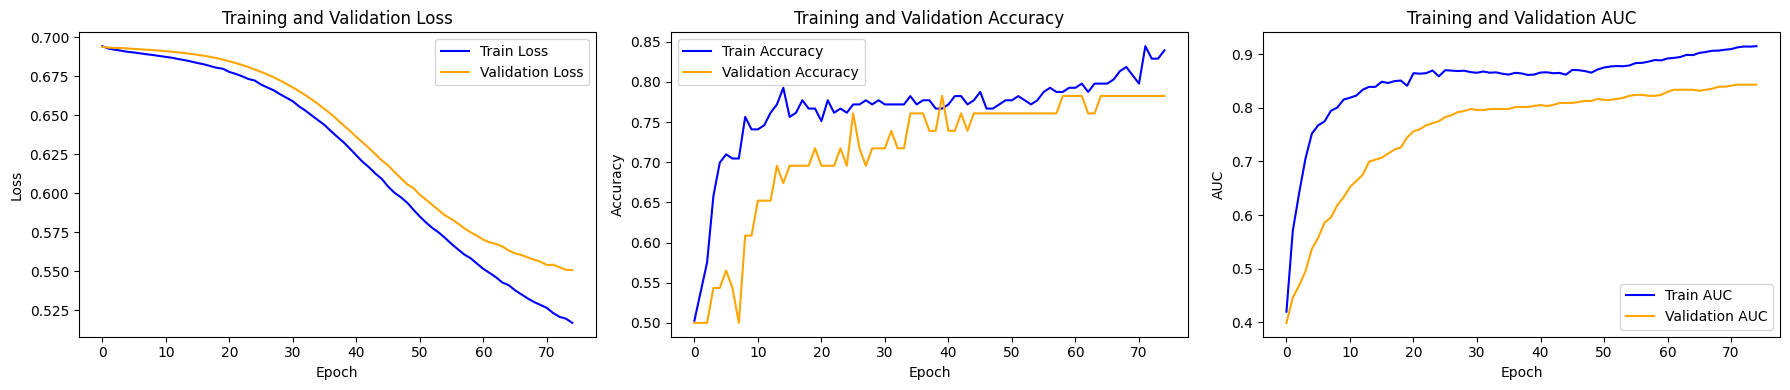

Training finished!
Test Accuracy: 1.0000
Test AUC: 1.0000
Training metrics saved to 'DH vs NR metrics/DH_vs_NR_2025-06-25_12-06.csv'


In [13]:
#### Block 4 #### 
### Training and validation ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64 # Neural network density
output_dim = 2  # Set model to binary classification

# Hyperparameters
num_epochs = 75
learning_rate = 0.001

# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.relu()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = F.softmax(x, dim=1) 
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())


    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

import pandas as pd
import os
from datetime import datetime

# Create the metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accuracies,
    'Validation_Accuracy': val_accuracies,
    'Train_AUC': train_aucs,
    'Validation_AUC': val_aucs
})

# Set your folder destination
output_folder = 'DH vs NR metrics'  # Customize if needed

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Generate timestamp without seconds
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
filename = f"DH_vs_NR_{timestamp}.csv"

# Full path to the output file
filepath = os.path.join(output_folder, filename)

# Save the DataFrame to CSV
metrics_df.to_csv(filepath, index=False)

print(f"Training metrics saved to '{filepath}'")

In [14]:
import torch
torch.save(model.state_dict(), '20250625_DHvsNR_75epoch.pth')
print("Model saved successfully!")

Model saved successfully!


In [13]:
# Initialize the model structure
model = MyGNN(input_dim, hidden_dim, output_dim)

# Load the saved model parameters
model.load_state_dict(torch.load('20240914_NRvsDH_80epoch.pth'))

# Make sure the model is in evaluation mode if you're using it for inference
model.eval()

MyGNN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

Processing batch with 3 graphs
Explanation for graph AceP2_Mod.1.pdb_aligned: tensor([0.0000e+00, 3.8329e-11, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5963e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


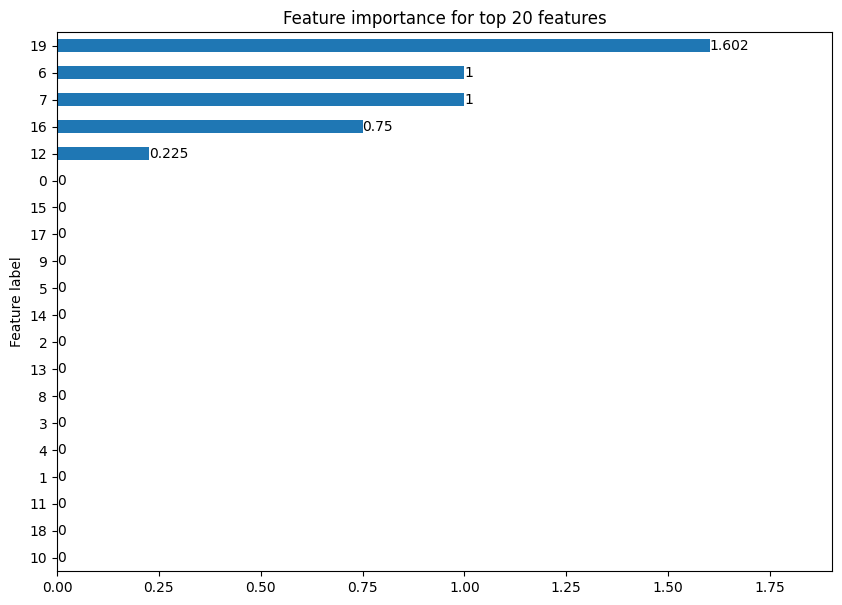

Explanation for graph merB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9759e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


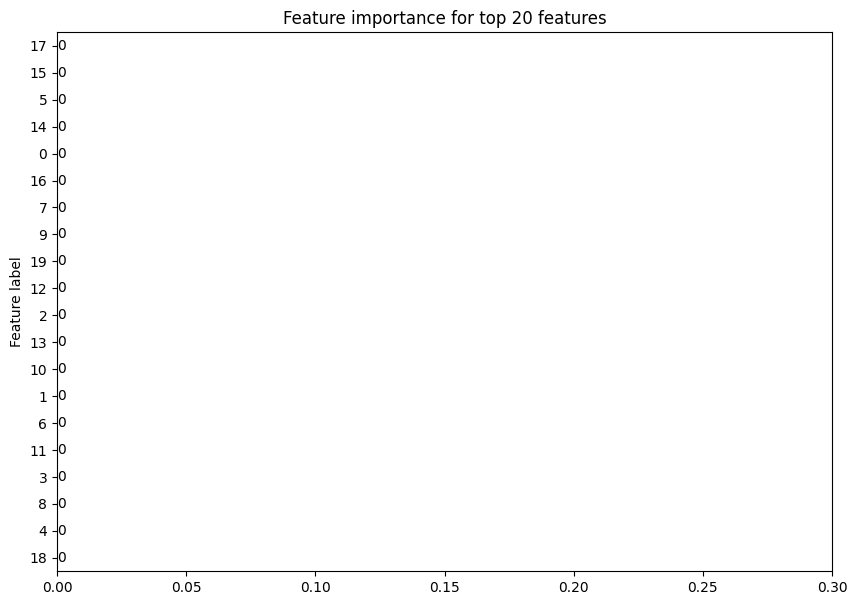

Explanation for graph lobA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5065e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


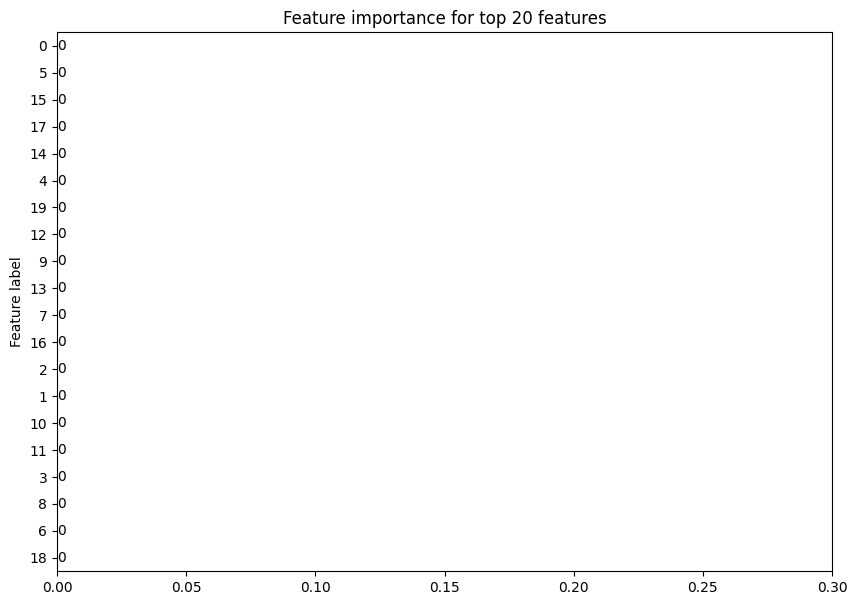

Processing batch with 46 graphs
Explanation for graph tmnAIII_Mod.2.pdb_aligned: tensor([0.0000e+00, 4.9282e-11, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


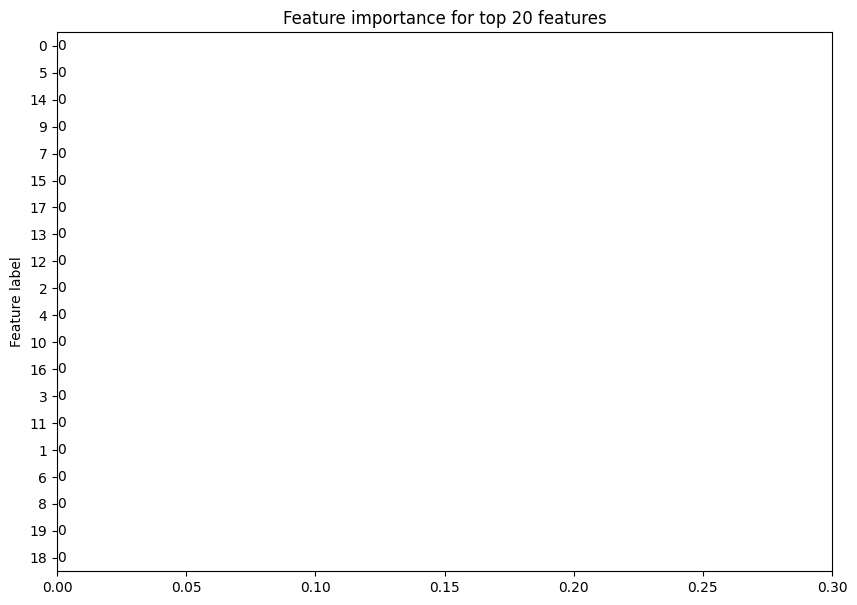

Explanation for graph fscD_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0805e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


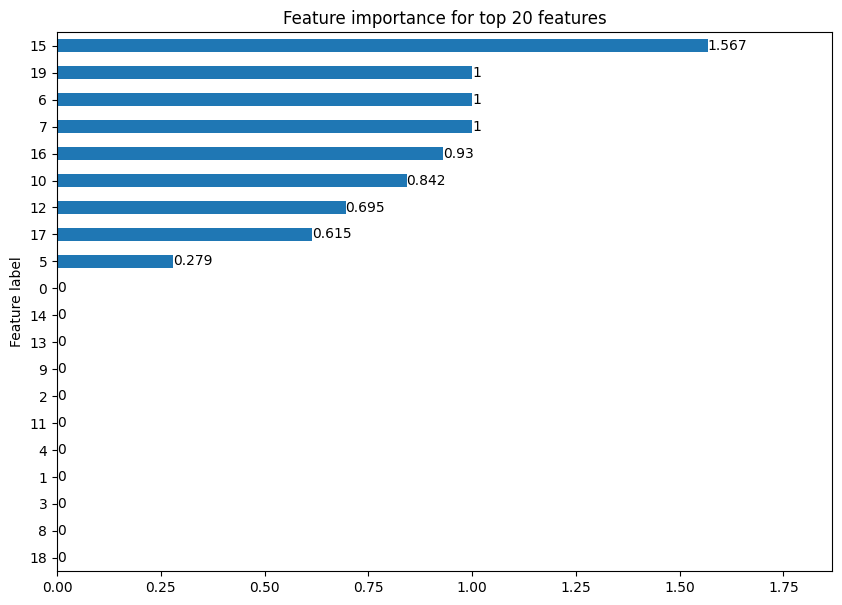

Explanation for graph AceP3_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9487e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


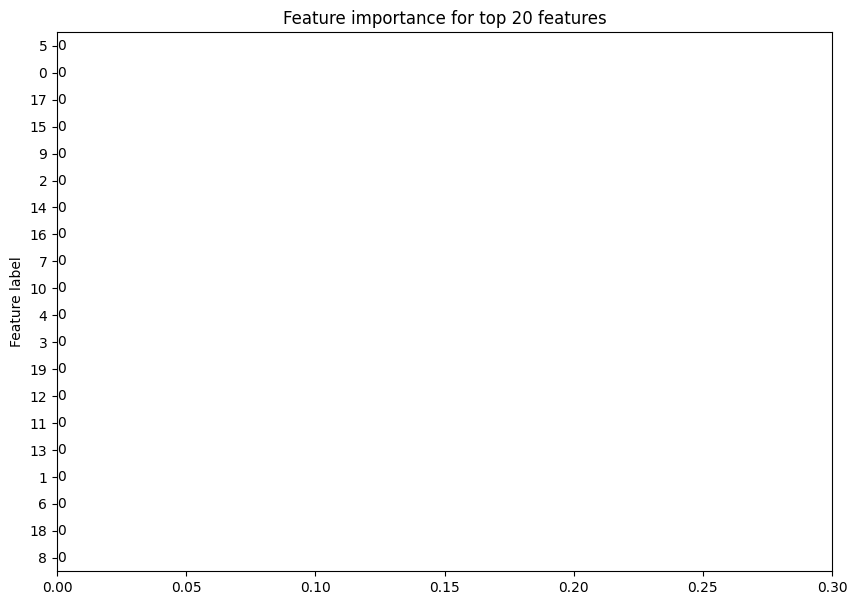

Explanation for graph spr9_Mod.5.pdb_aligned: tensor([4.4860e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0539e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


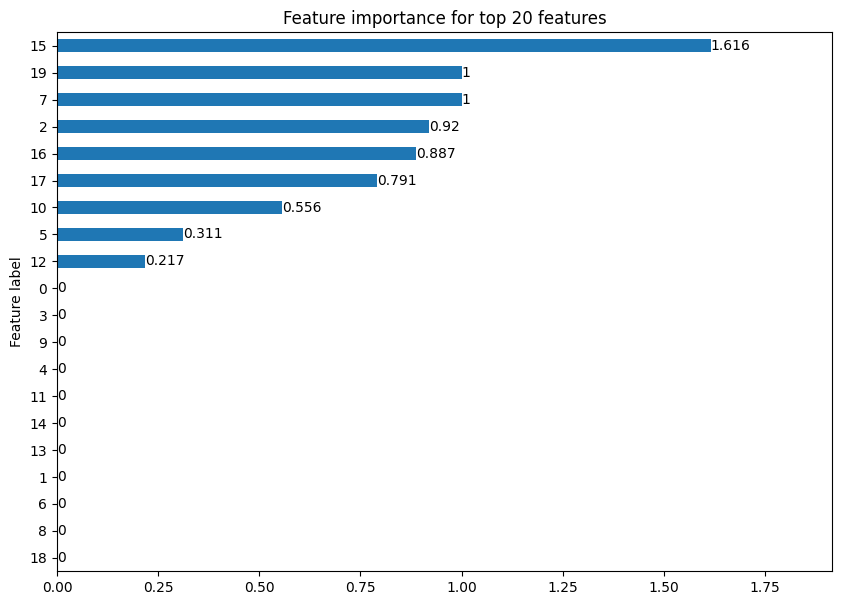

Explanation for graph asmA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


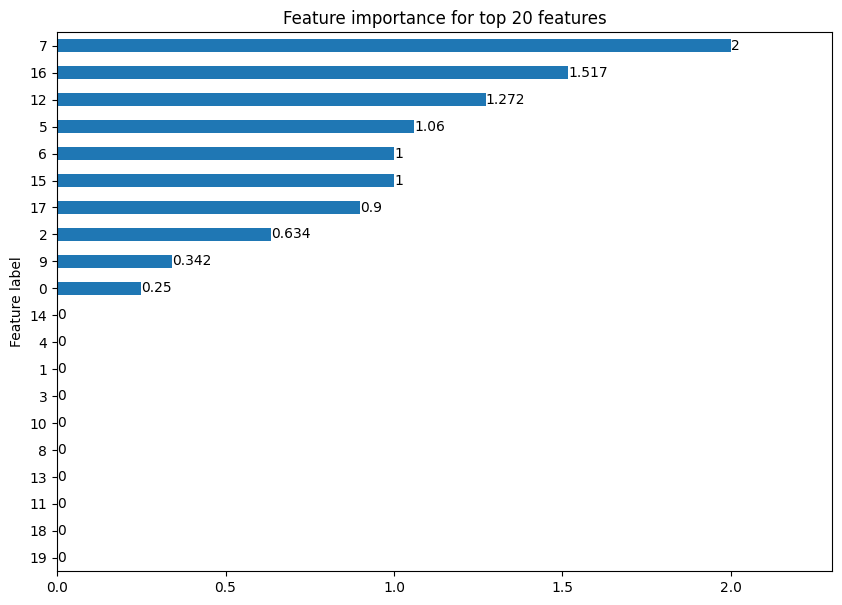

Explanation for graph slnA7_Mod.1.pdb_aligned: tensor([4.8774e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.0206e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


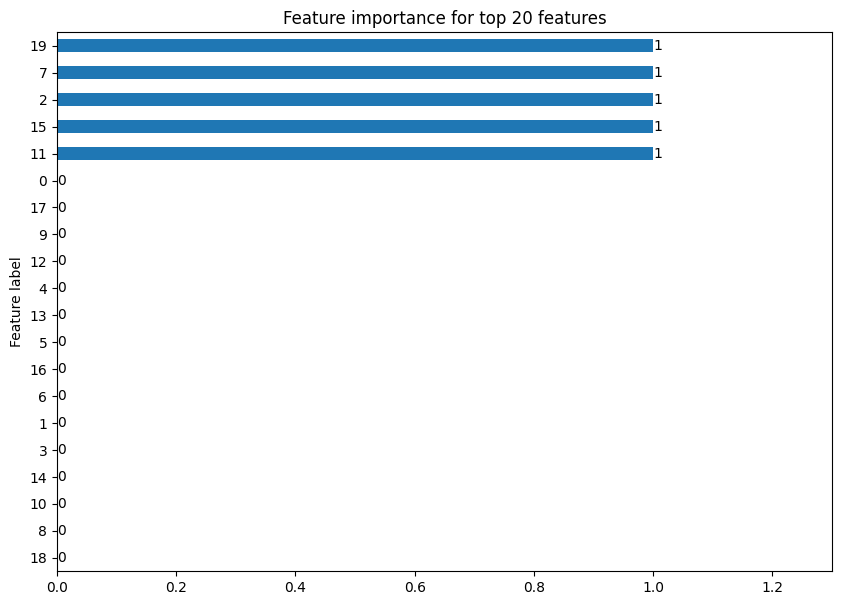

Explanation for graph natC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


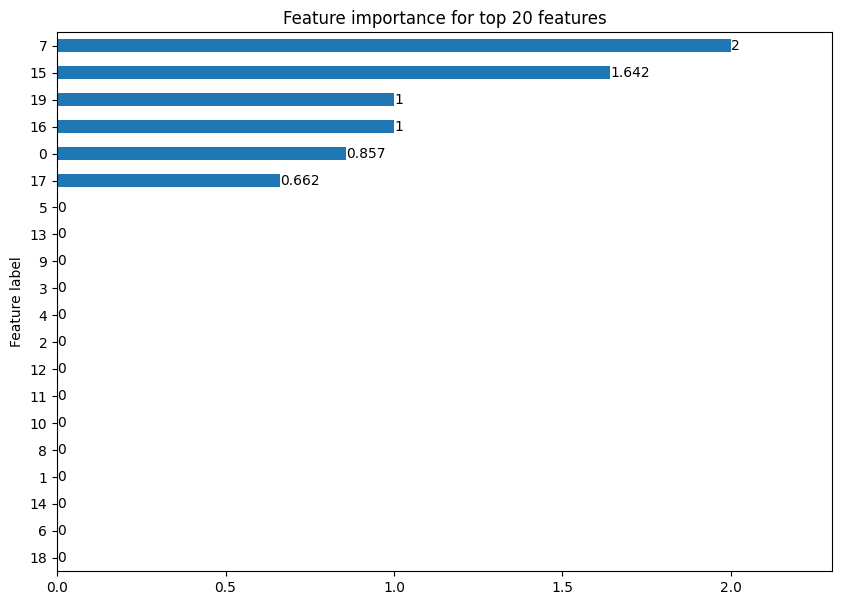

Explanation for graph hgcA_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


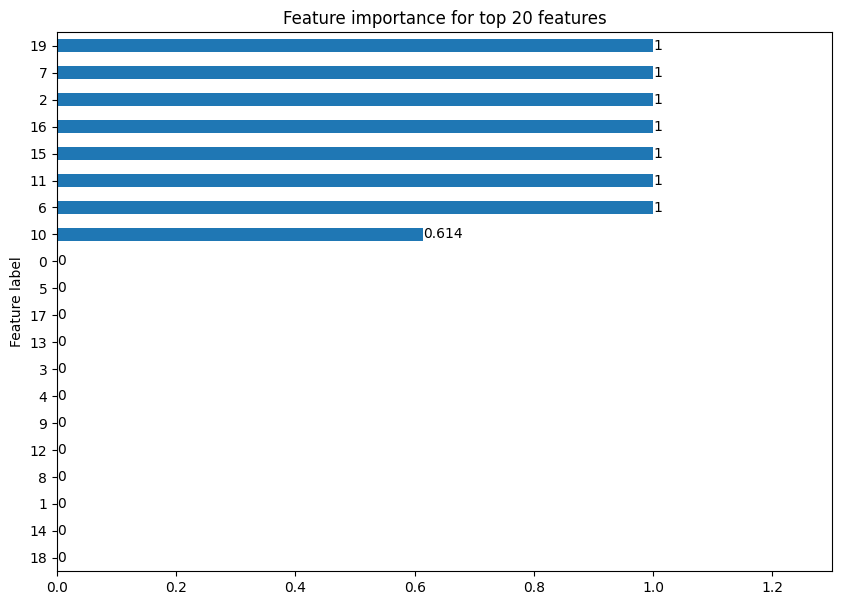

Explanation for graph olmA7_Mod.16.pdb_aligned: tensor([4.2425e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0065e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


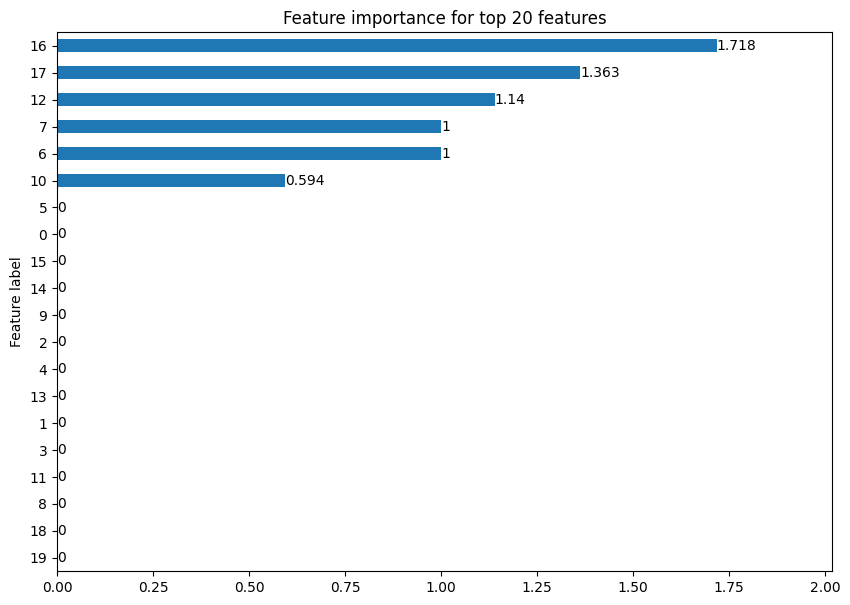

Explanation for graph tsnAI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7235e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


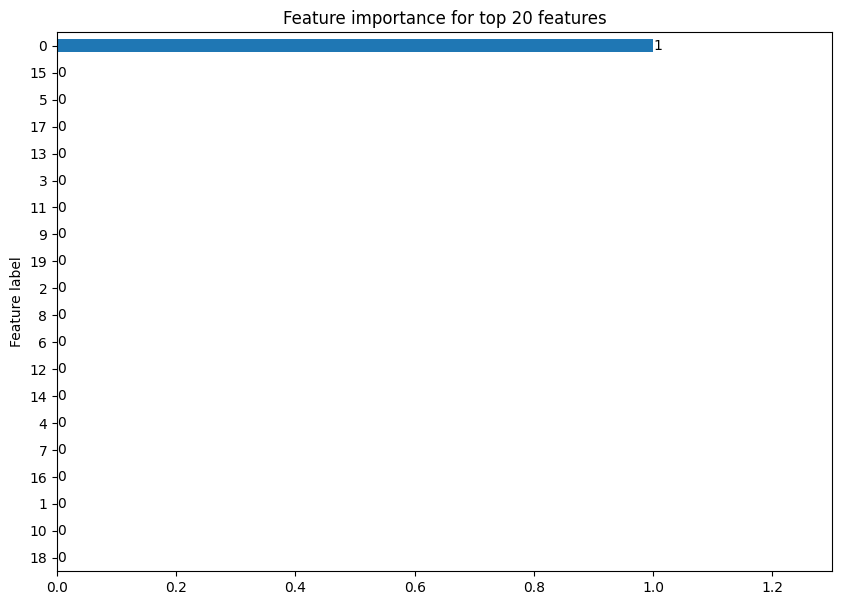

Explanation for graph hgcA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


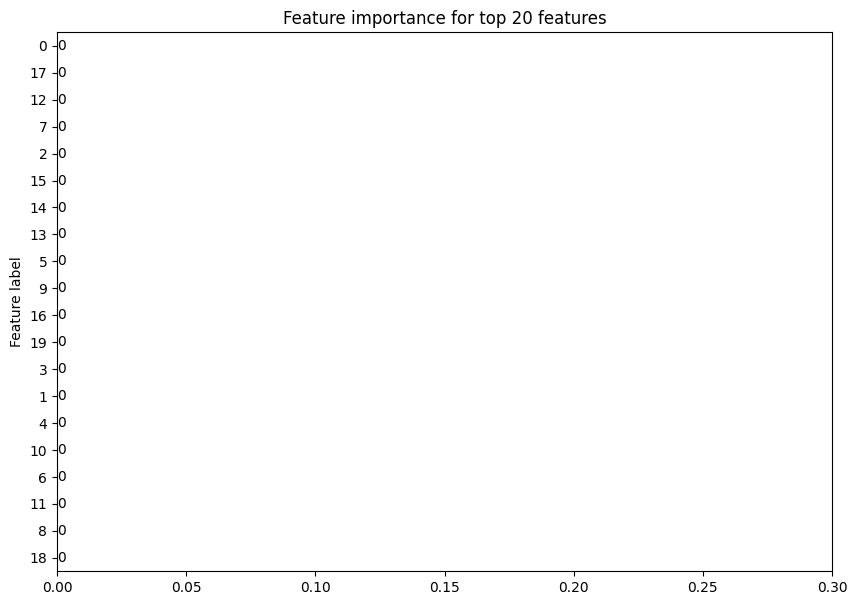

Explanation for graph slnA3_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1380e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


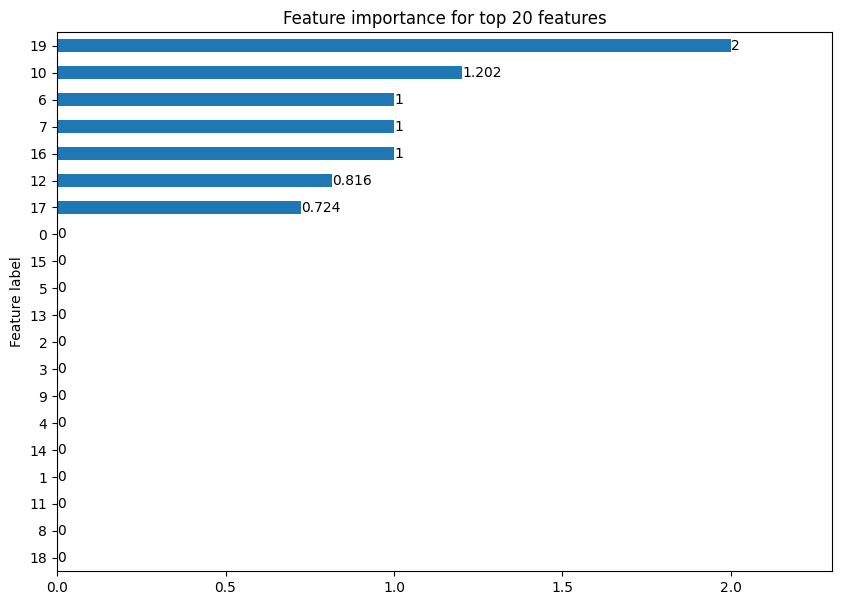

Explanation for graph selC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


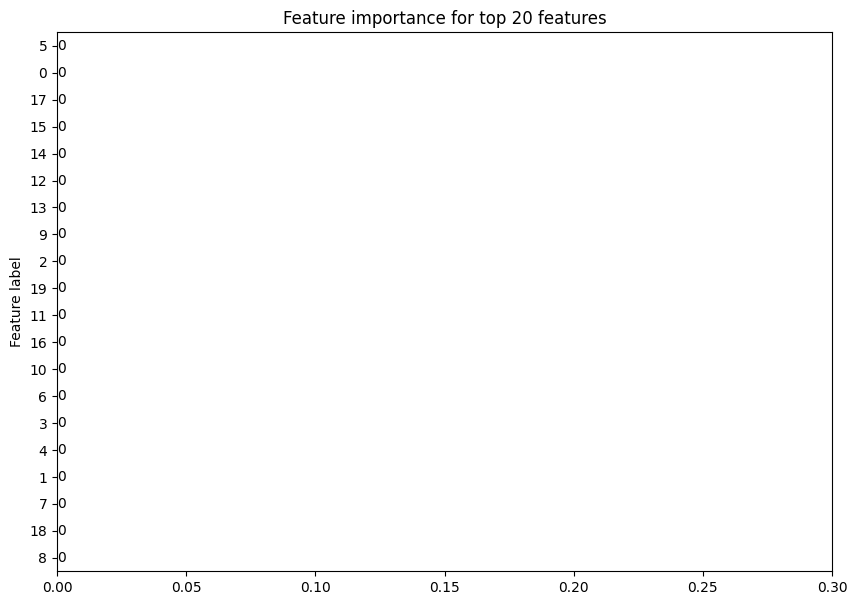

Explanation for graph slnA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6978e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


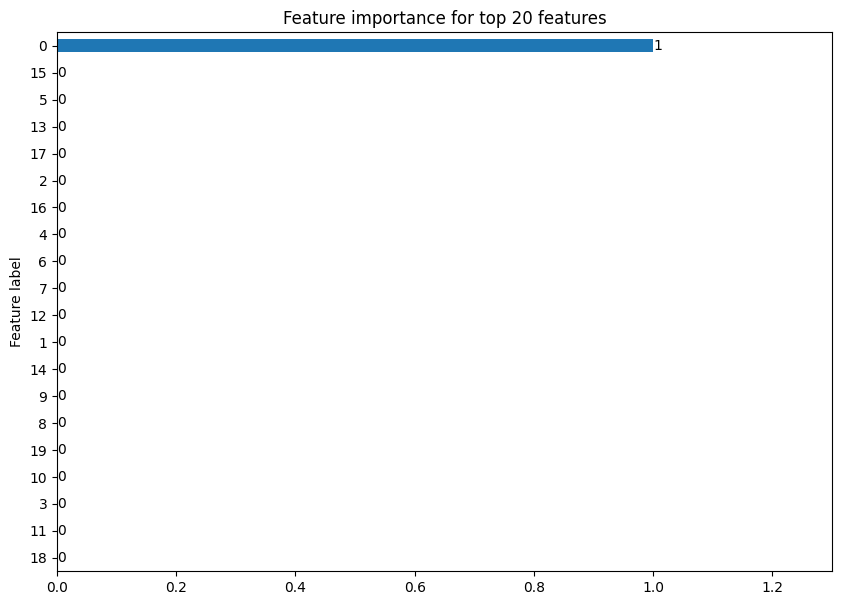

Explanation for graph lobA4_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


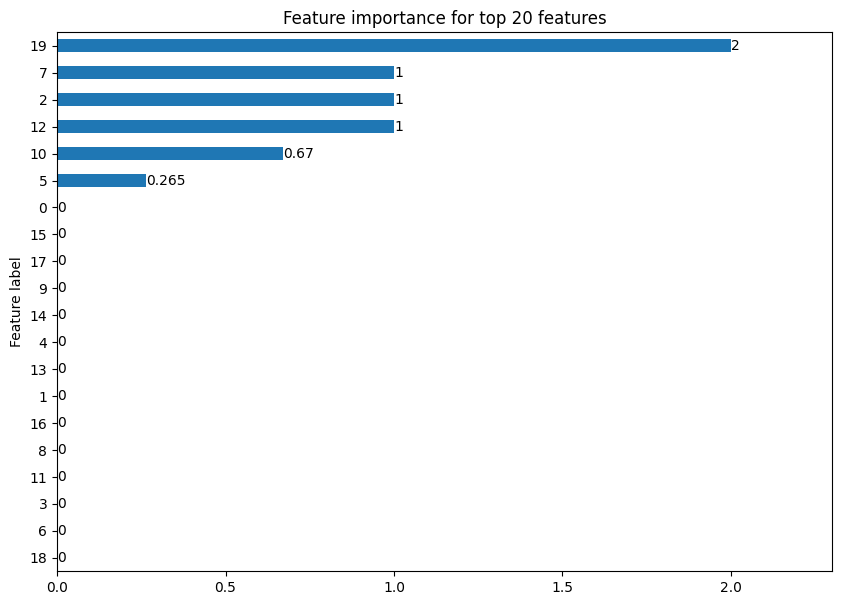

Explanation for graph epoC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9369e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


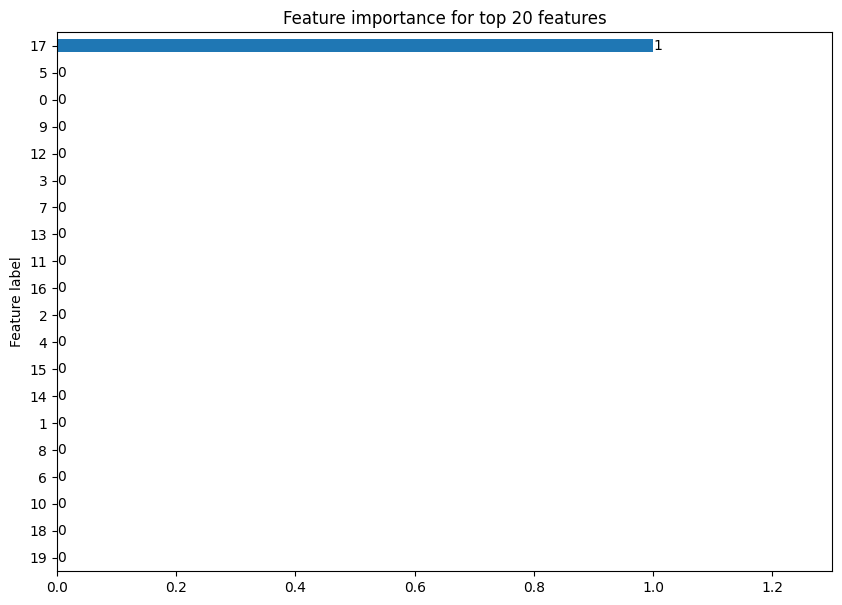

Explanation for graph mlaF_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7726e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


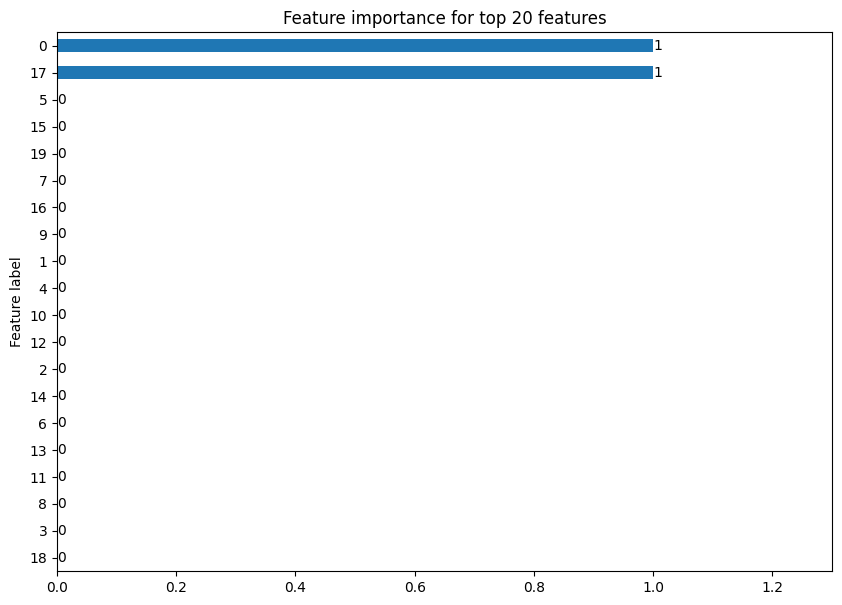

Explanation for graph StamE_Mod.14.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 3.9465e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6869e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


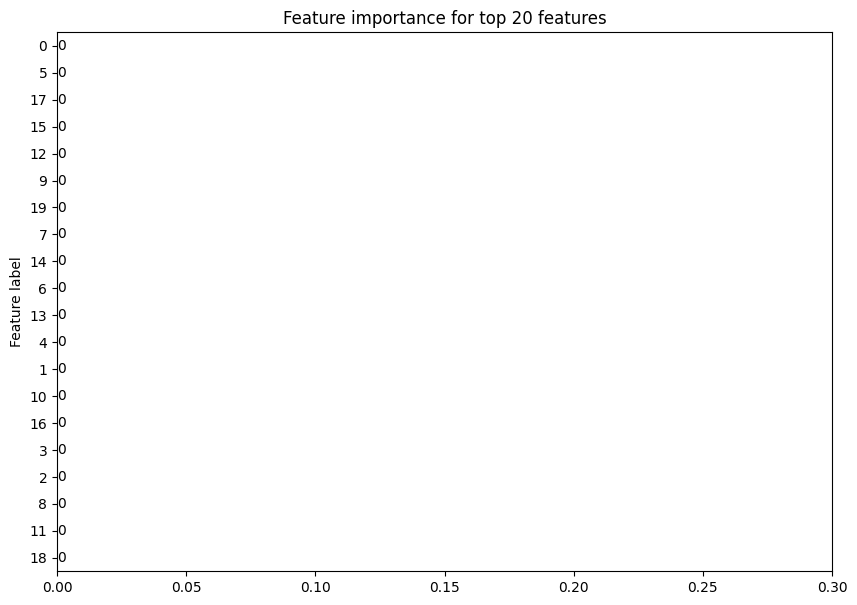

Explanation for graph gphG_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


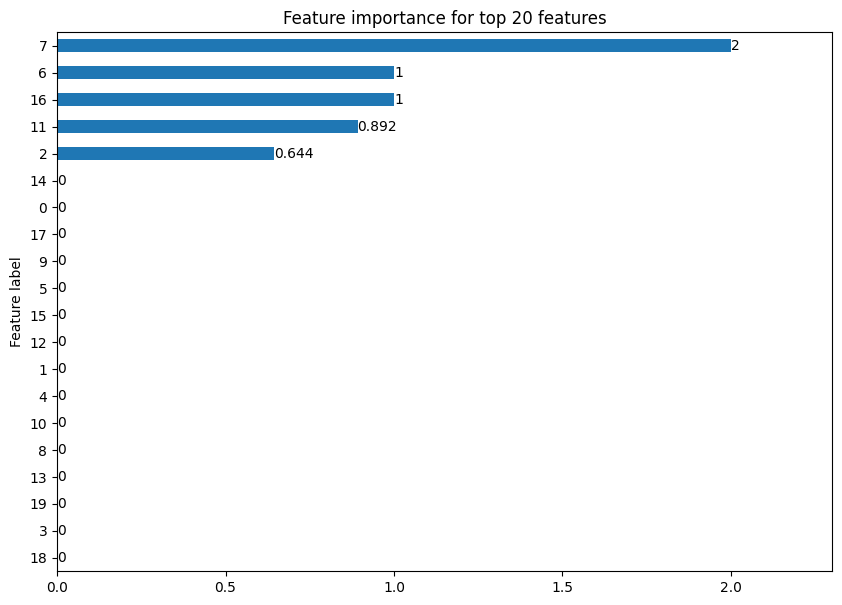

Explanation for graph lasAIV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5170e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


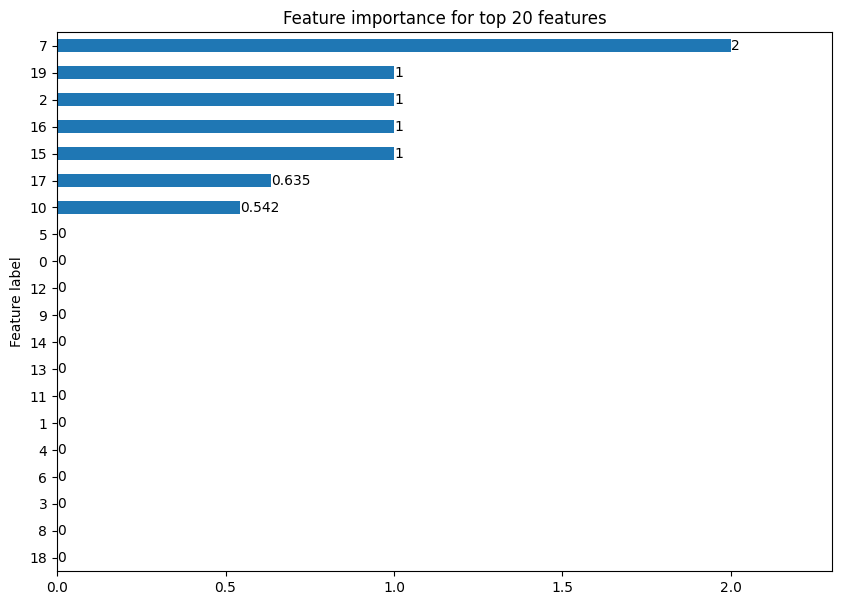

Explanation for graph meiA4_Mod.3.pdb_aligned: tensor([4.5294e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


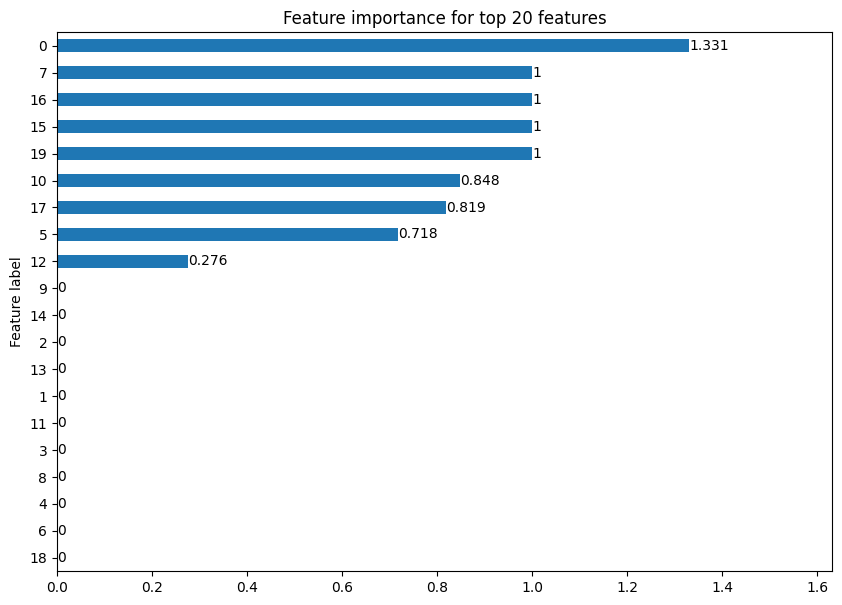

Explanation for graph rapA_Mod.4.pdb_aligned: tensor([4.4097e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9490e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


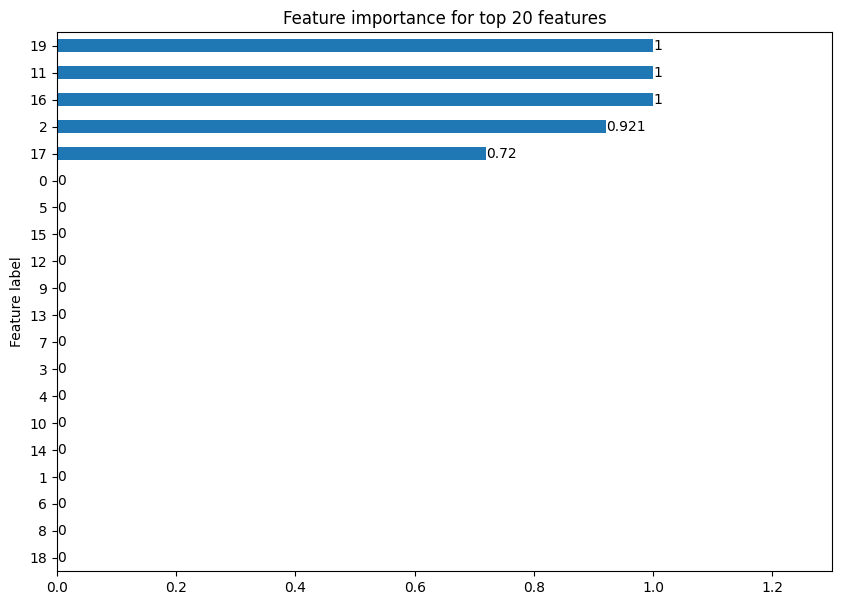

Explanation for graph stzC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


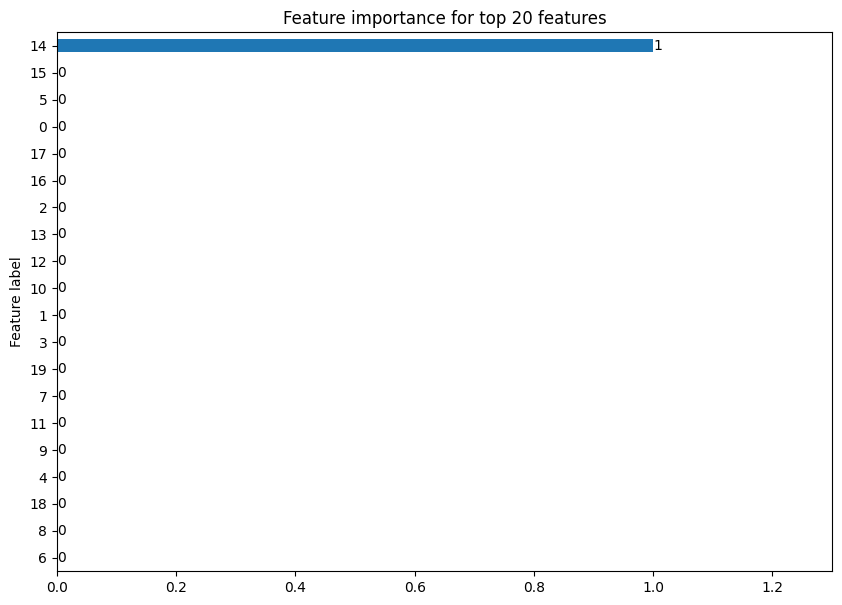

Explanation for graph cxmB_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2972e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


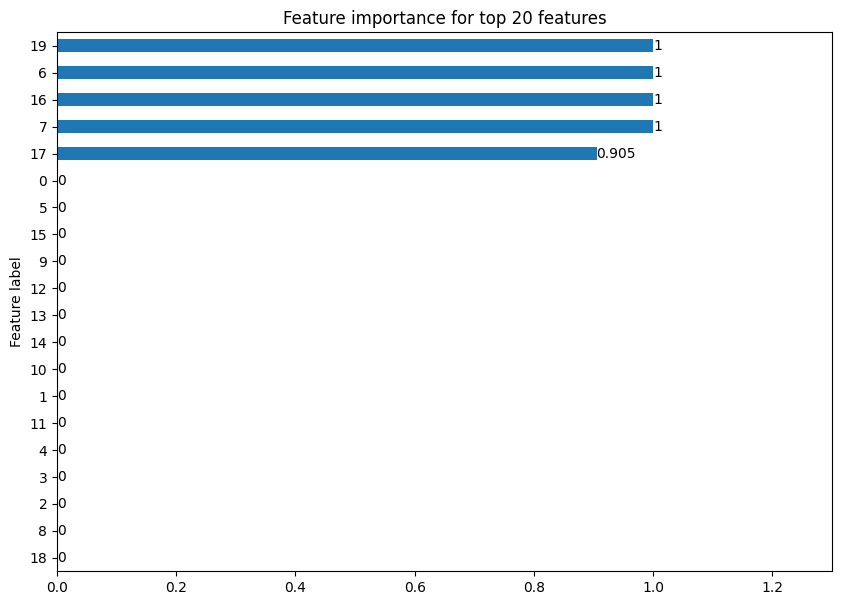

Explanation for graph cle5_Mod.3.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 5.6791e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


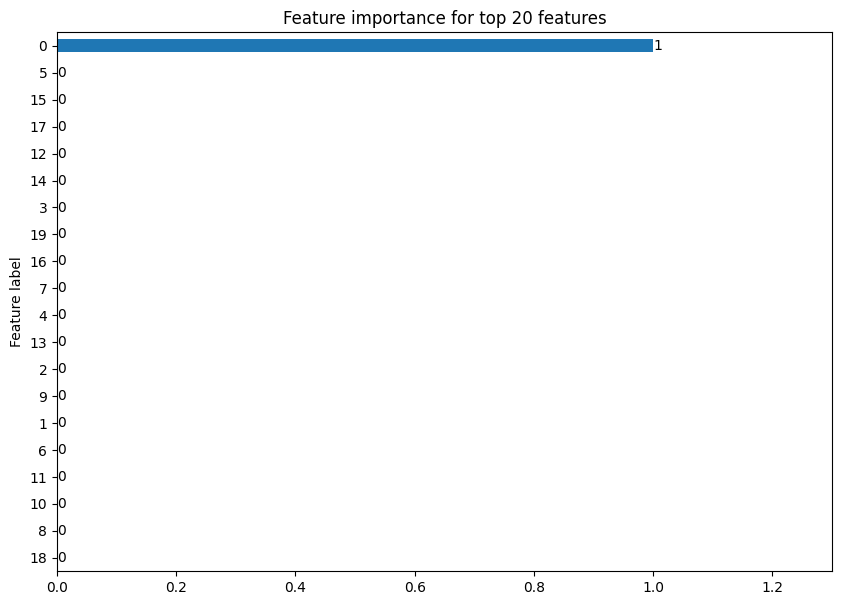

Explanation for graph cle1_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


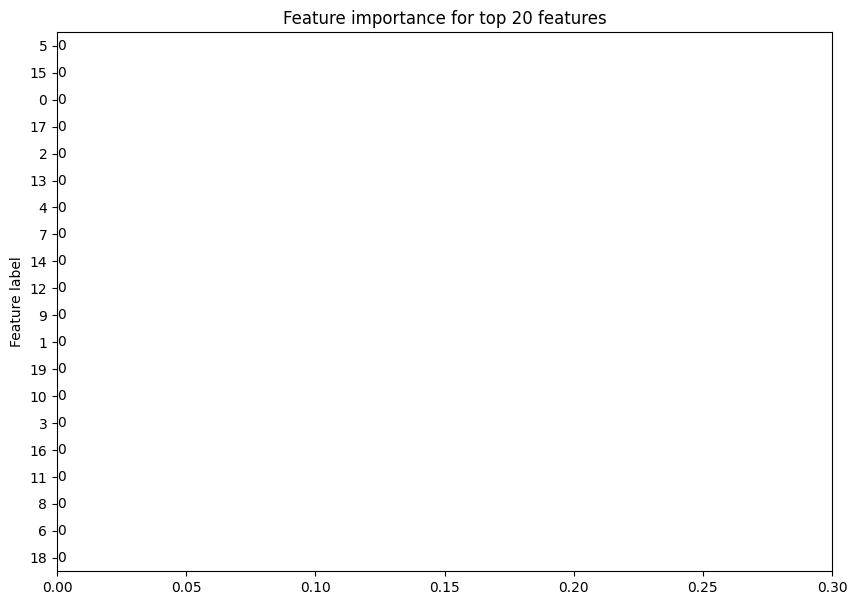

Explanation for graph btlB_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2086e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


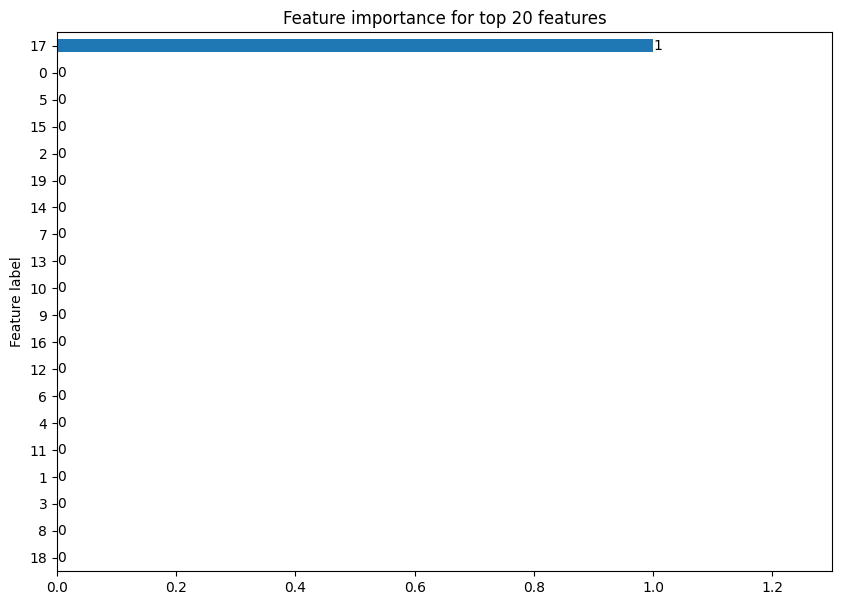

Explanation for graph becB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.3250e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


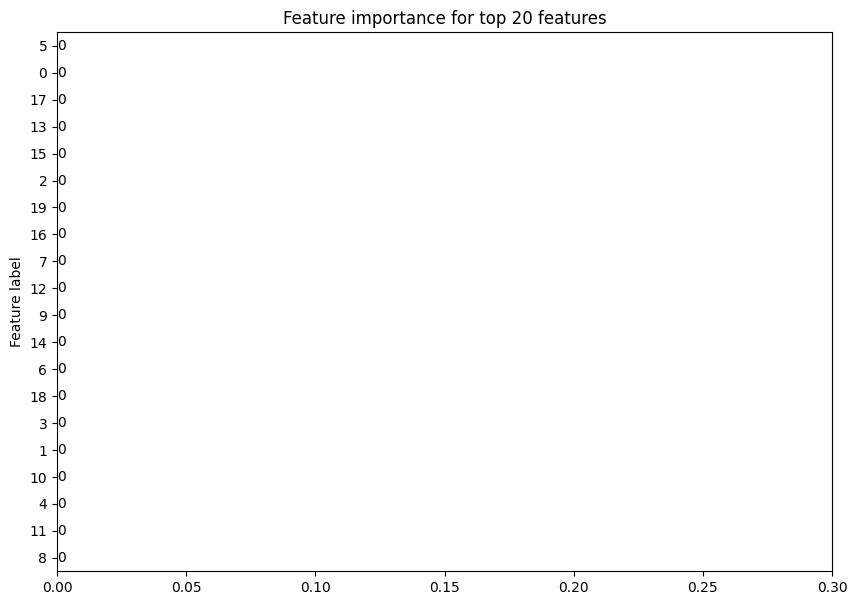

Explanation for graph AbsB3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.8175e-10, 0.0000e+00,
         0.0000e+00],
        [4.8163e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


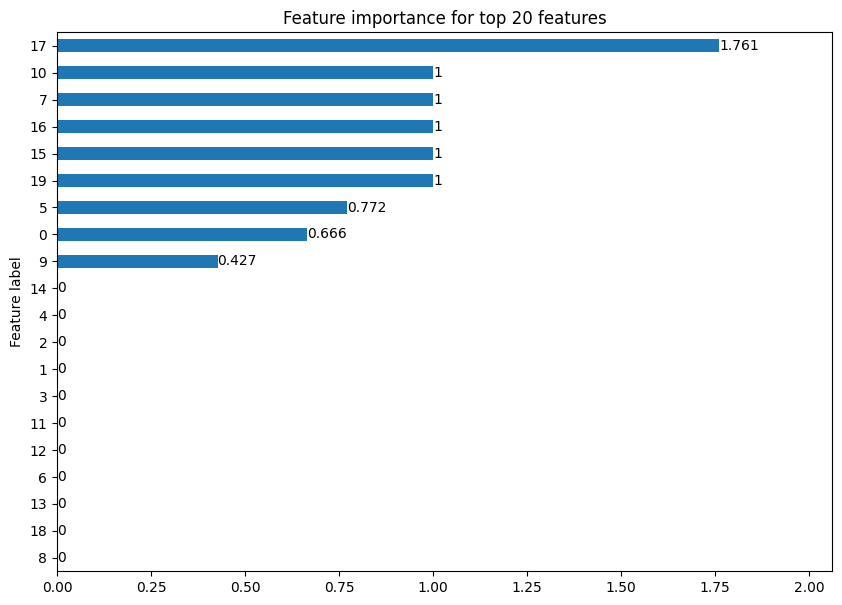

Explanation for graph scnS2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


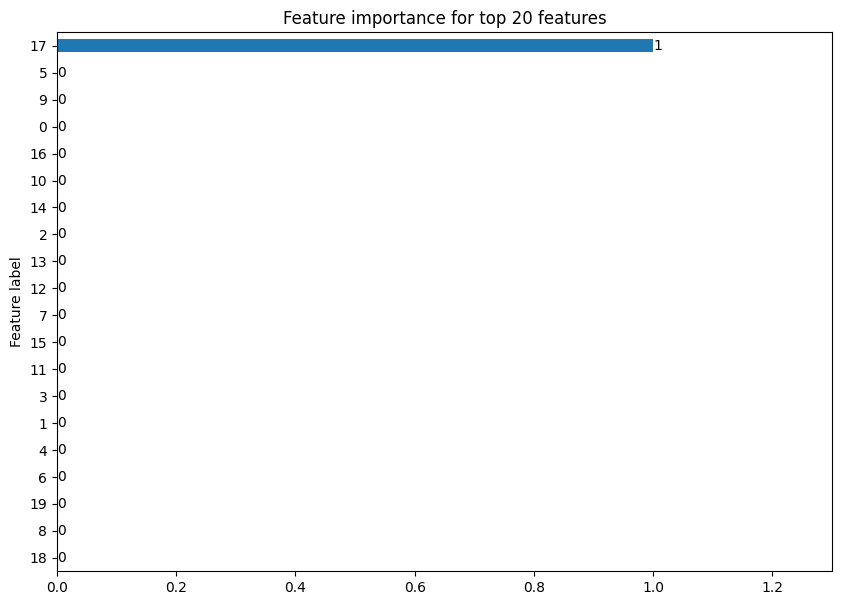

Explanation for graph TamAIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.3004e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


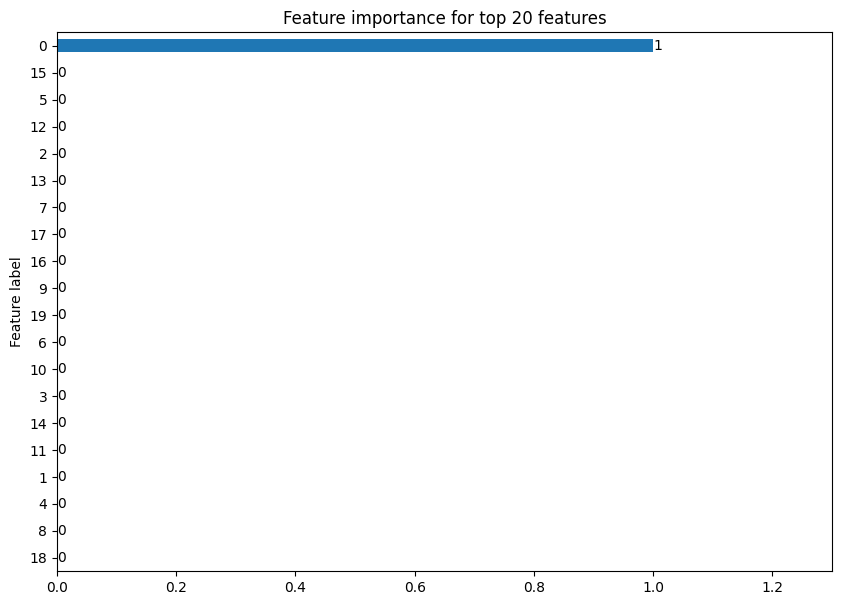

Explanation for graph slgA3_Mod.1.pdb_aligned: tensor([6.2511e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4194e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


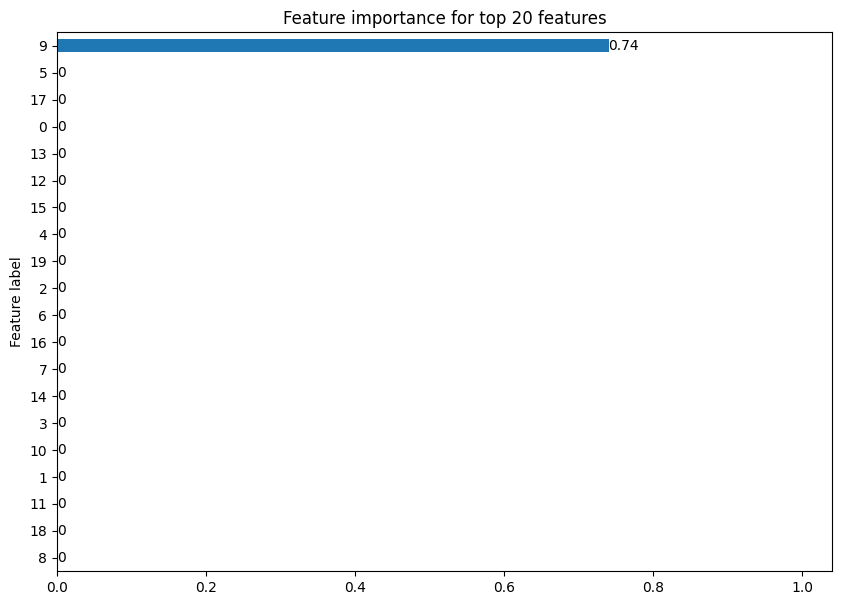

Explanation for graph cppI_Mod.6.pdb_aligned: tensor([5.7948e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5741e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


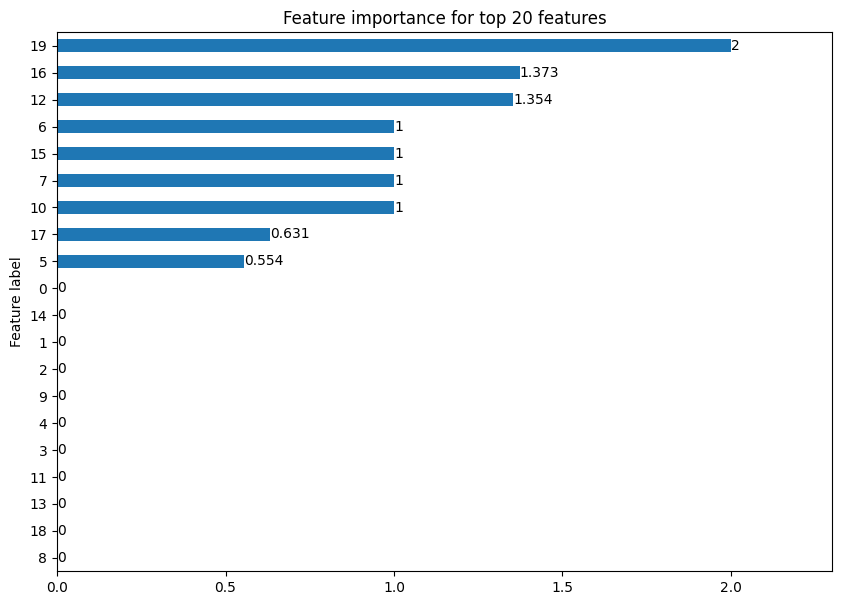

Explanation for graph chmGIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


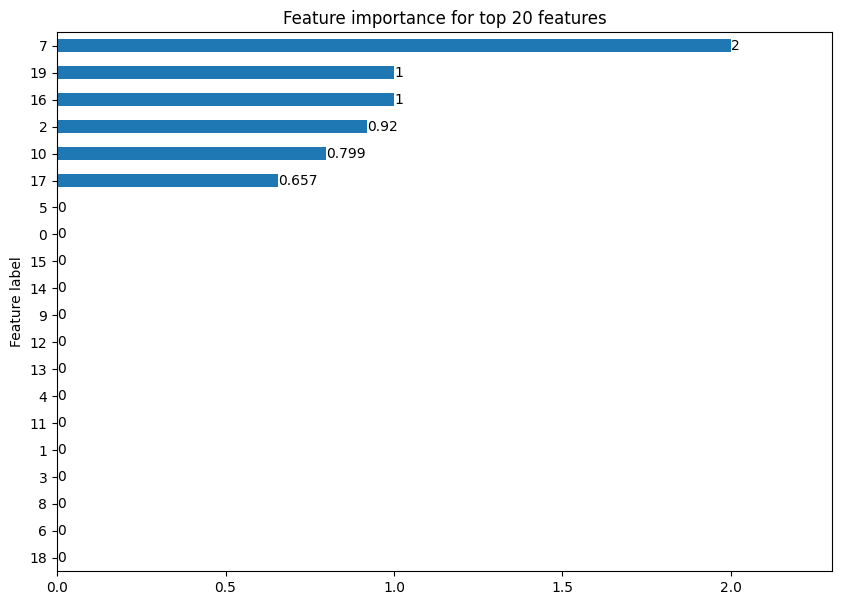

Explanation for graph meiA2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6878e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


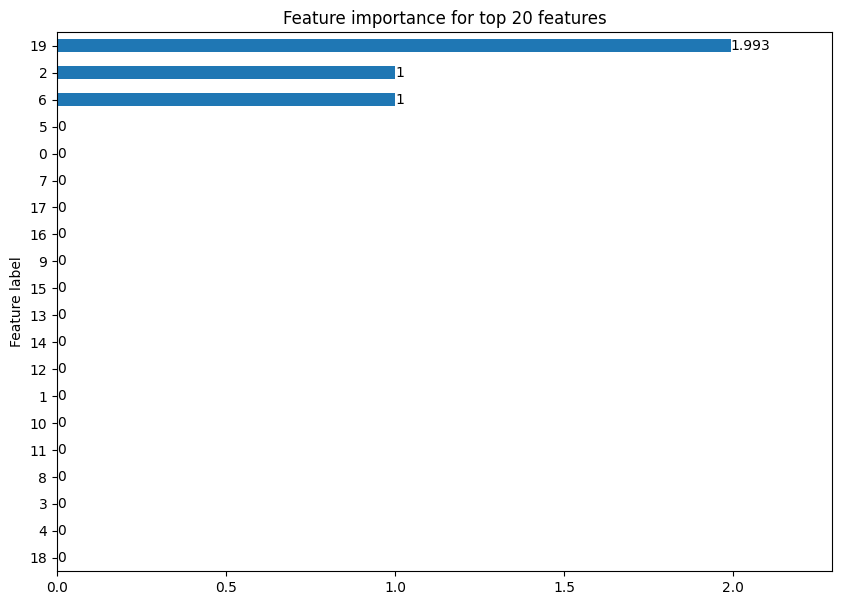

Explanation for graph nanA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


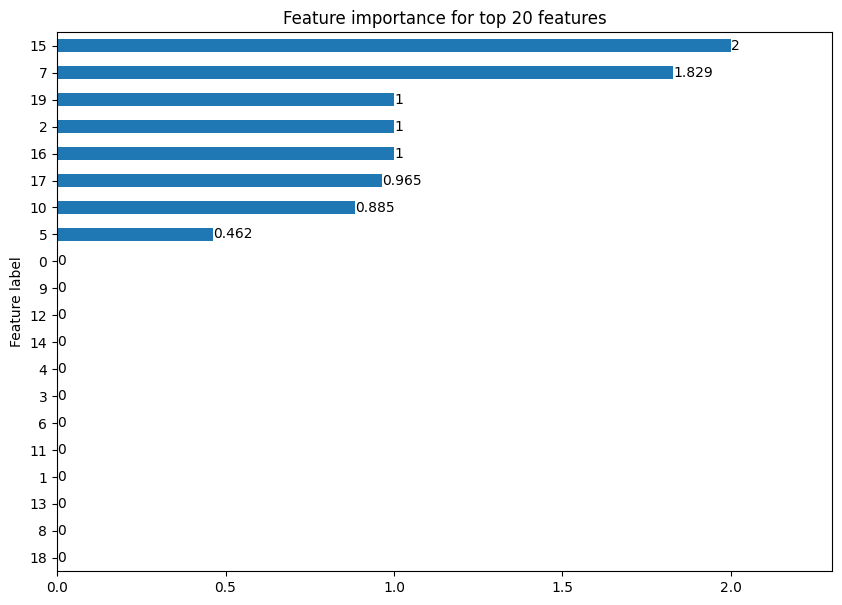

Explanation for graph palD_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6036e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


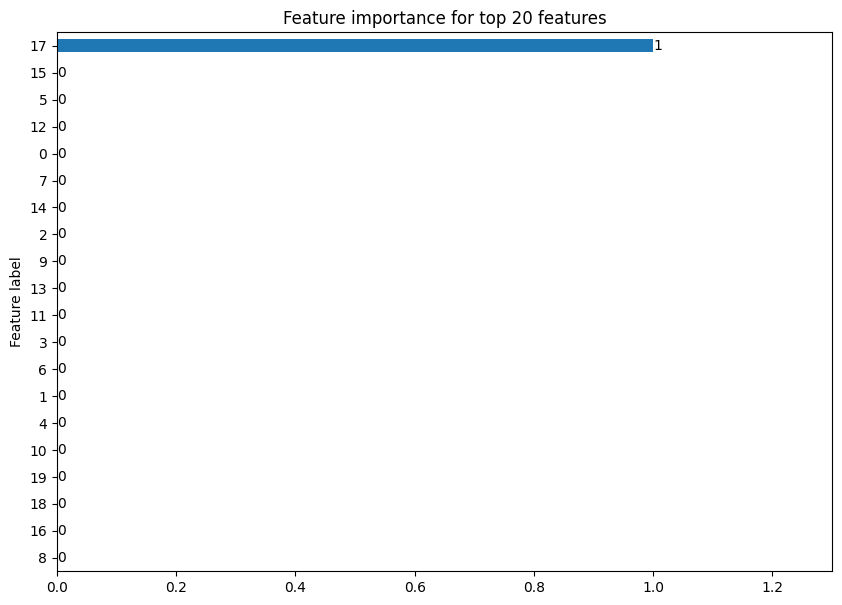

Explanation for graph lasAI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4335e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


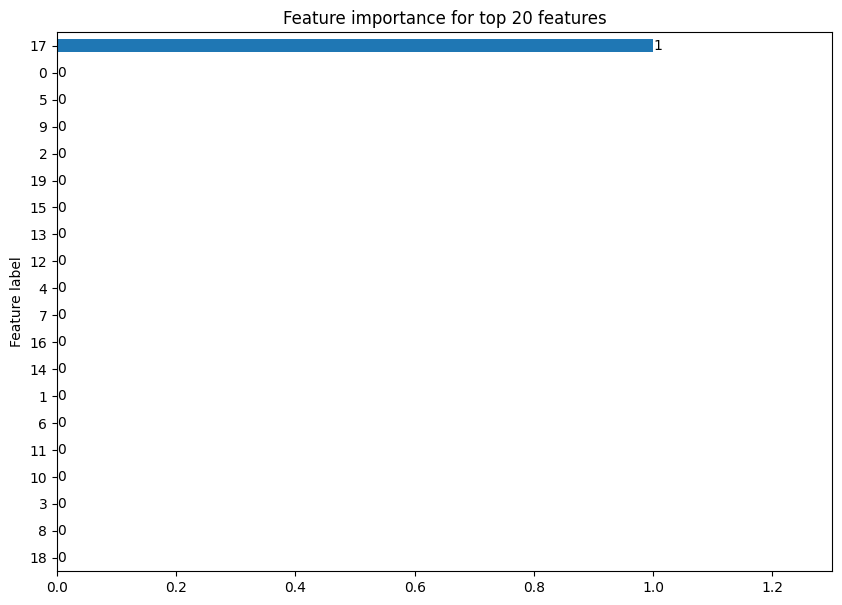

Explanation for graph cppC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9427e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


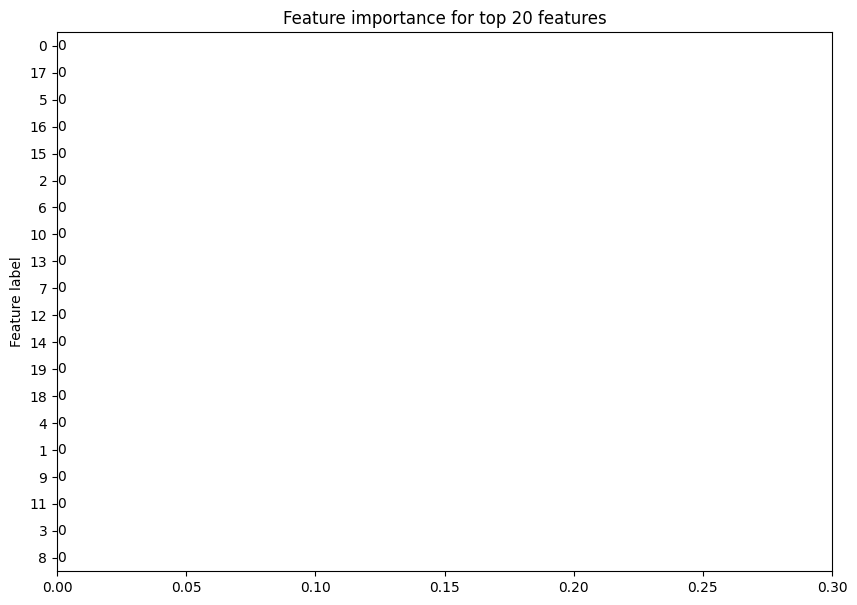

Explanation for graph gerSIII_Mod.1.pdb_aligned: tensor([4.5740e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.1176e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


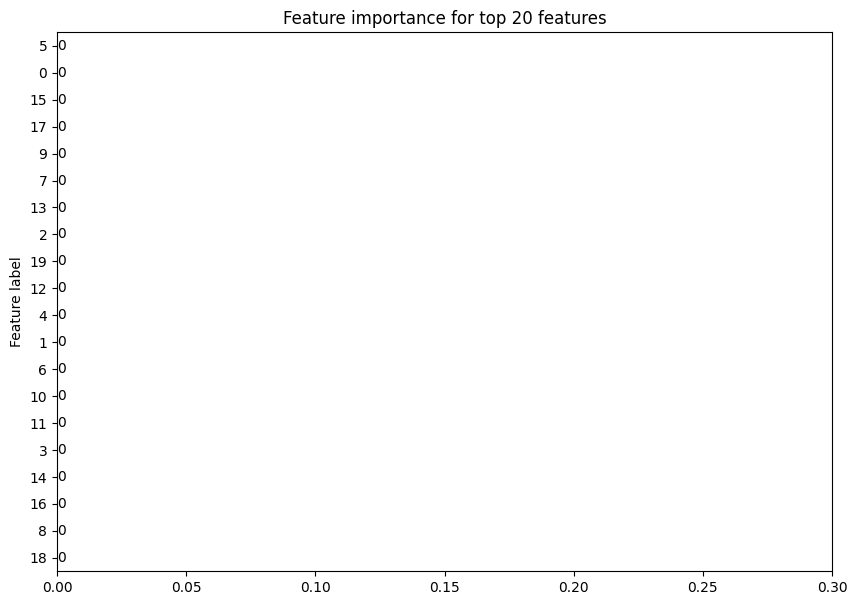

Explanation for graph ladSII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9494e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


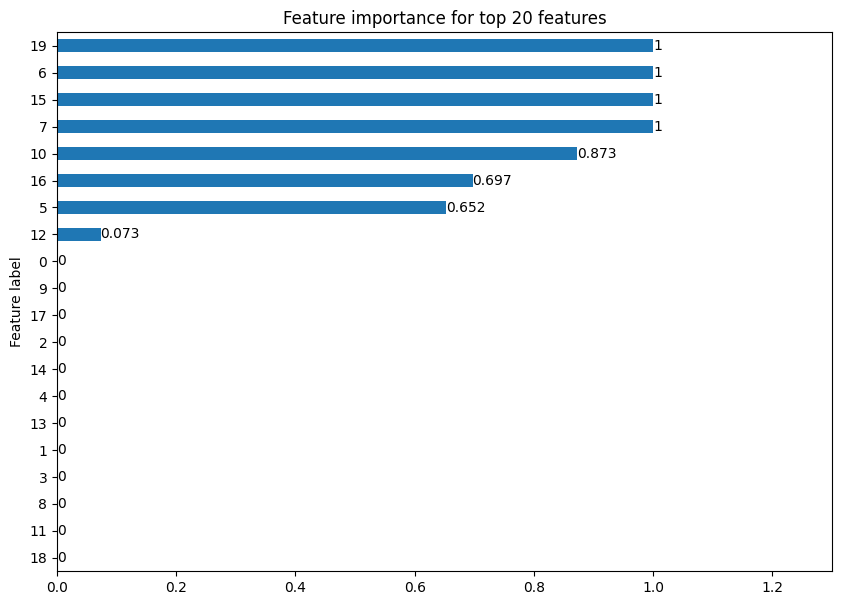

Explanation for graph olmA2_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


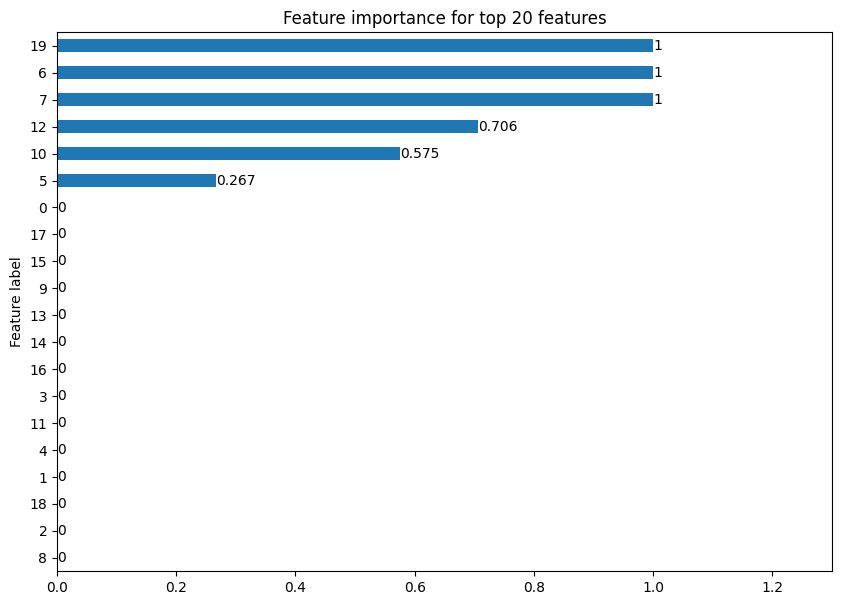

Explanation for graph phn2_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


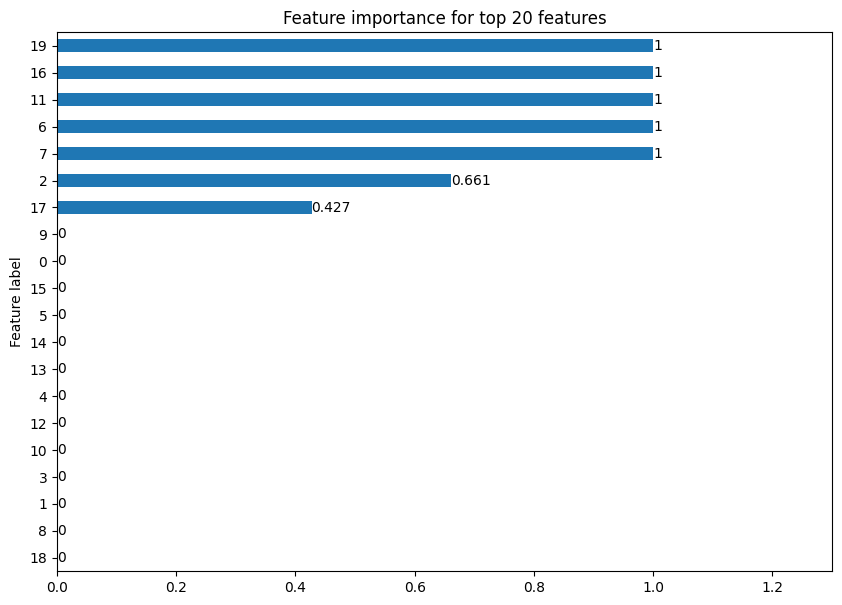

Explanation for graph scnS2_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0395e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0577e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


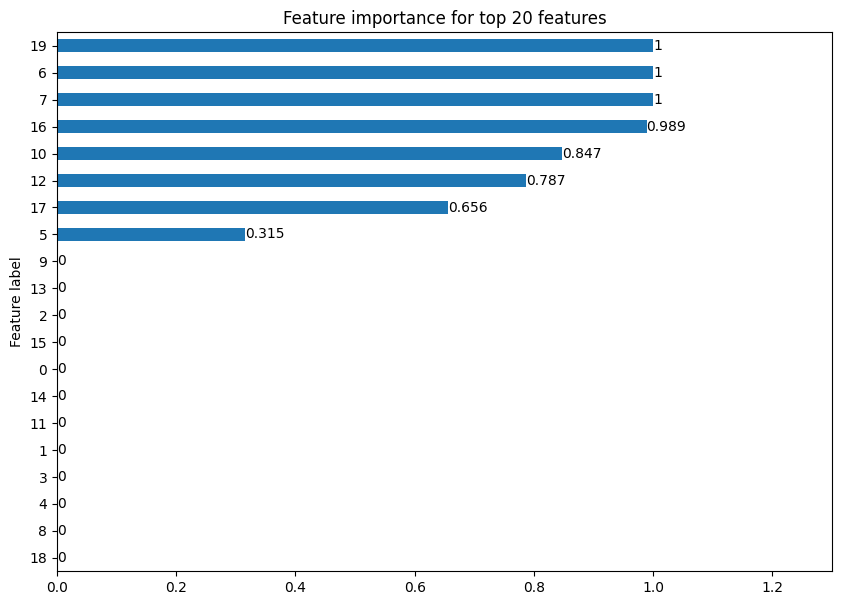

Explanation for graph lobA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4128e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


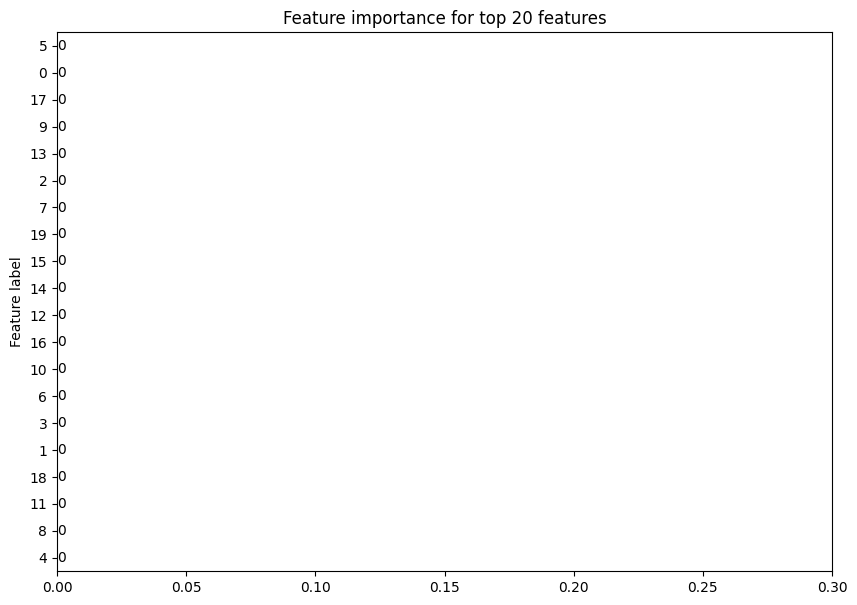

Explanation for graph fkbC_Mod.2.pdb_aligned: tensor([4.4653e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9025e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


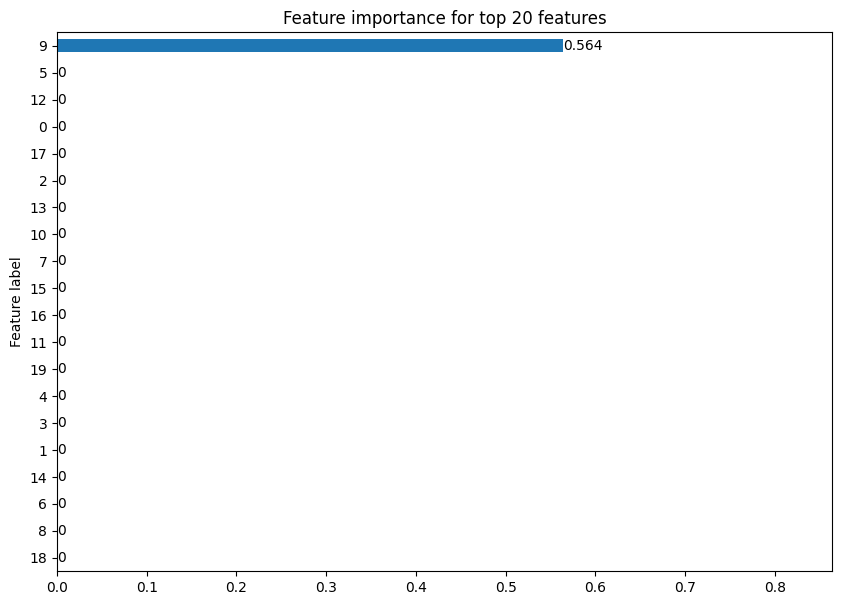

In [15]:
#### Block 5 ####
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd

# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/03 KS B reduction state binary classifiers/DH vs NR metrics"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = test_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader
loader = val_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
